# Project 2 Clustering

In [1]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import (confusion_matrix, homogeneity_score, completeness_score, 
v_measure_score, adjusted_rand_score, adjusted_mutual_info_score)
from sklearn.decomposition import TruncatedSVD, NMF
import matplotlib.pyplot as plt
import itertools


min_df = 3
categories = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
              'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey']

print("fetch data")
eightTrainingData = fetch_20newsgroups(subset='all', categories=categories)
# eightTrainingData = fetch_20newsgroups(subset='all', categories=categories,
#                                 remove=('headers','footers','quotes'))
eightLabels = [int(x / 4) for x in eightTrainingData.target]

fetch data


## Function for Plotting Contingency Matrix

In [176]:
# plot contingency matrix plot
def plot_contingency_matrix(label_true, label_pred, classname, normalize=False, title='Contingency Matrix', fs=None):
    plt.figure()
    cmat = confusion_matrix(label_true, label_pred)
    cmap = plt.cm.Blues
    
    if fs is not None:
        plt.figure(figsize=(fs,fs))
    plt.imshow(cmat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classname))
    plt.xticks(tick_marks, classname, rotation=45)
    plt.yticks(tick_marks, classname)

    if normalize:
        cmat = cmat.astype('float') / cmat.sum(axis=1)[:, np.newaxis]

    # print(cmat)

    thresh = cmat.max() / 2.
    for i, j in itertools.product(range(cmat.shape[0]), range(cmat.shape[1])):
        if normalize == False:
            plt.text(j, i, cmat[i, j], horizontalalignment="center", color="white" if cmat[i, j] > thresh else "black")
        else:
            plt.text(j, i, "%.2f"%cmat[i, j], horizontalalignment="center", color="white" if cmat[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## Function for making normal plot

In [3]:
# ys has the format [[y1,y1_label],[y2, y2_label]]
def make_plot(x, ys, xlabel, ylabel, xticks=None, grid=False, title=None):
    for y, label in ys:
        plt.plot(x, y, label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if xticks is not None:
        plt.xticks(x)
    plt.legend()
    if grid == True:
        plt.grid()
    if title is not None:
        plt.title(title)
    plt.show()

## Problem 1. Building the TF-IDF matrix

In [ ]:
print("=" * 60)
"""
Problem 1: Building the TF-IDF matrix.
"""
print('-' * 60)
pipe = Pipeline( [
    ('vect', CountVectorizer(min_df=3, analyzer='word', stop_words='english')),
    ('tfidf', TfidfTransformer())
] )
TFIDF = pipe.fit_transform(eightTrainingData.data)
print("p1: dimension of the TF-IDF matrix is: ", TFIDF.shape)

## Probelm 2. Apply K-means clustering with k = 2 using the TF-IDF data

------------------------------------------------------------


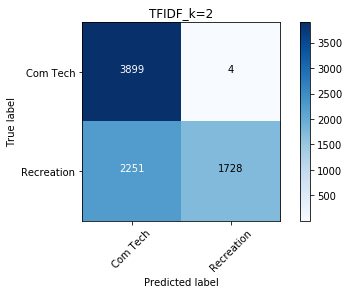

In [103]:
"""
Problem 2: Apply K-means clustering with k = 2 using the TF-IDF data.
"""
print('-' * 60)
km = KMeans(n_clusters=2, max_iter=10, n_init=10)
km.fit(TFIDF)
class_names = ['Com Tech', 'Recreation']
title = 'TFIDF_k=2'
plot_contingency_matrix(eightLabels, km.labels_, class_names, normalize=False, title=title)

In [112]:
"""
Problem 2b: Apply K-means clustering with k = 2 using the TF-IDF data.
"""
print("Homogeneity: %0.3f" % homogeneity_score(eightLabels, km.labels_))
print("Completeness: %0.3f" % completeness_score(eightLabels, km.labels_))
print("V-measure: %0.3f" % v_measure_score(eightLabels, km.labels_))
print("Adjusted rand score: %.3f" % adjusted_rand_score(eightLabels, km.labels_))
print("Adjusted mutual info score: %.3f" % adjusted_mutual_info_score(eightLabels, km.labels_))

Homogeneity: 0.255
Completeness: 0.336
V-measure: 0.290
Adjusted rand score: 0.183
Adjusted mutual info score: 0.255


## Problem 3. Dimensionality reduction

In [12]:
"""
Problem 3: Apply SVD, NMF to TFIDF and plot measure scores vs n_components.
"""
print('-' * 60)

# SVD
rank = 1000
svd = TruncatedSVD(n_components=rank)
svd_X = svd.fit_transform(TFIDF)


------------------------------------------------------------


### Problem 3 (i). Report the percent of variance

[ 0.00119855  0.006365    0.01000796  0.01356696  0.01677614  0.01932803
  0.0218225   0.02423317  0.02654565  0.02872857]


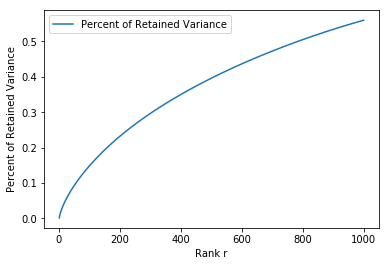

<class 'numpy.ndarray'>
(7882, 2)


In [13]:
ratios = np.array([])
sum = 0
for ratio in svd.explained_variance_ratio_:
    sum = sum + ratio
    ratios = np.append(ratios, sum)
print(ratios[0:10])
x = np.array(range(1,rank+1))
y = [[ratios,'Percent of Retained Variance']]
xlabel = 'Rank r'
ylabel = 'Percent of Retained Variance'
make_plot(x, y, xlabel, ylabel)
print(type(svd_X))
print(svd_X[:,:2].shape)

### Problem 3 (ii). Apply SVD and NMF

In [80]:
def prob_3a_ii(method, XData=None):
    ranks = np.array([1,2,3,5,10,20,50,100,300])
    np_hg = np.array([])
    np_cp = np.array([])
    np_vm = np.array([])
    np_ari = np.array([])
    np_ami = np.array([])
    class_names = ['Com Tech', 'Recreation']

    for r in ranks:
        if method == 'NMF':
            nmf = NMF(n_components=r, max_iter=(50 if r==300 else 200))
            data = nmf.fit_transform(TFIDF)
        else:
            data = XData[:,:r]
        km = KMeans(n_clusters=2, max_iter=100, n_init=40)
        km.fit(data)

        title = str(method)+' Rank '+str(r)
        plot_contingency_matrix(eightLabels, km.labels_, class_names, 
                               normalize=False, title=title)

        np_hg = np.append(np_hg, homogeneity_score(eightLabels, km.labels_))
        np_cp = np.append(np_cp, completeness_score(eightLabels, km.labels_))
        np_vm = np.append(np_vm, v_measure_score(eightLabels, km.labels_))
        np_ari = np.append(np_ari, adjusted_rand_score(eightLabels, km.labels_))
        np_ami = np.append(np_ami, adjusted_mutual_info_score(eightLabels, km.labels_))

    x = ranks
    ys = [[np_hg, 'Homogeneity'],[np_cp, 'Completeness'], [np_vm, 'V_measure']]
    xlabel = 'Rank r'
    ylabel = 'Score'
    title = str(method)+' Score'
    make_plot(x, ys, xlabel, ylabel, title=title)
    ys = [[np_ari, 'Adjusted Rand Index'], [np_ami, 'Adjusted Mutual Info']]
    make_plot(x, ys, xlabel, ylabel, title=title)
    return np_hg, np_cp, np_vm, np_ari, np_ami

### SVD

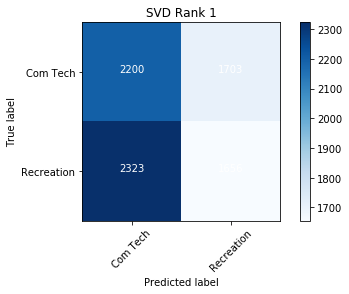

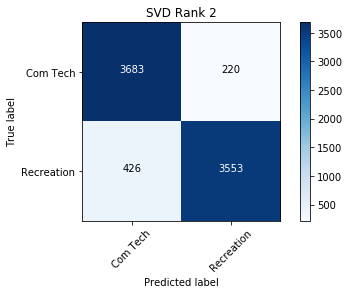

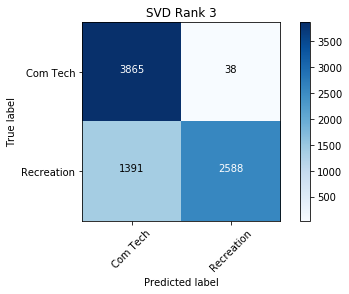

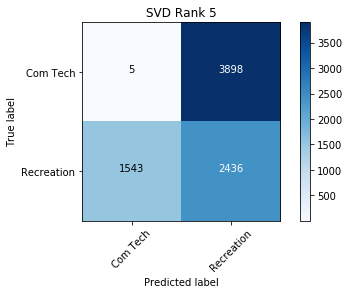

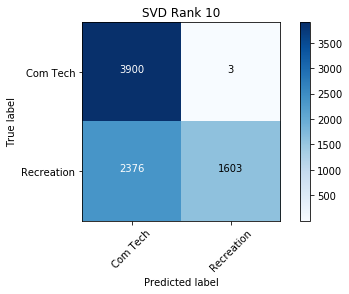

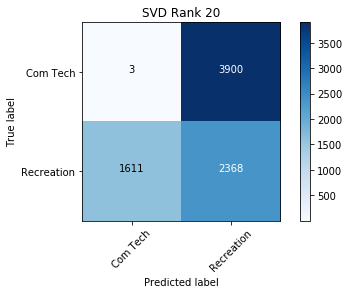

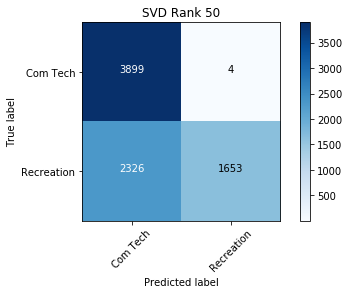

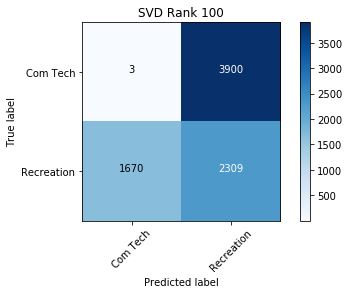

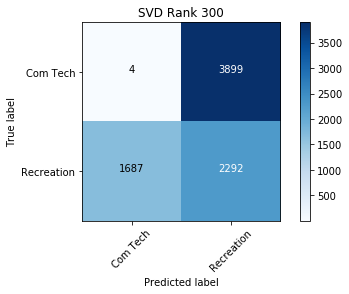

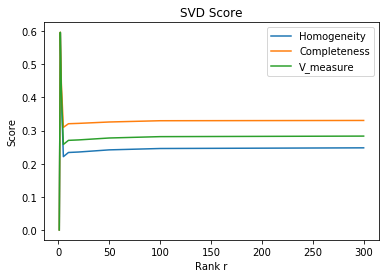

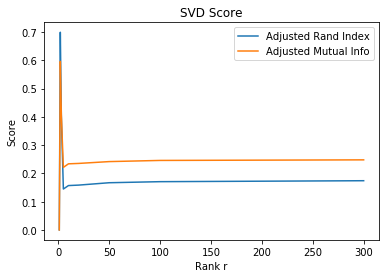

In [26]:
# problem 3 (a) ii
# SVD
hg, cp, vm, ari, ami = prob_3a_ii('SVD', svd_X)

In [27]:
print(hg)
print(cp)
print(vm)
print(ari)
print(ami)

[  2.99299087e-04   5.95949429e-01   4.07665665e-01   2.21345717e-01
   2.33914810e-01   2.35335998e-01   2.41805770e-01   2.45913685e-01
   2.47946283e-01]
[  3.04080277e-04   5.96691866e-01   4.43989243e-01   3.09699636e-01
   3.20684055e-01   3.21754017e-01   3.25899622e-01   3.29721454e-01
   3.30541751e-01]
[  3.01670739e-04   5.96320416e-01   4.25052843e-01   2.58172631e-01
   2.70511732e-01   2.71842254e-01   2.77624311e-01   2.81716707e-01
   2.83347602e-01]
[  3.39090736e-04   6.98995295e-01   4.06207799e-01   1.44769243e-01
   1.56993311e-01   1.58606668e-01   1.67004476e-01   1.70759732e-01
   1.74132739e-01]
[  2.07775692e-04   5.95912438e-01   4.07611435e-01   2.21274421e-01
   2.33844665e-01   2.35265983e-01   2.41736348e-01   2.45844640e-01
   2.47877424e-01]


### NMF

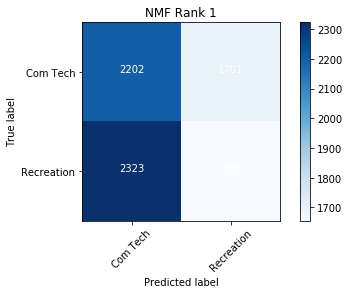

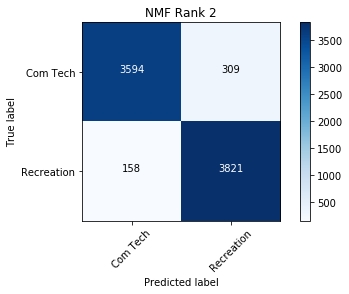

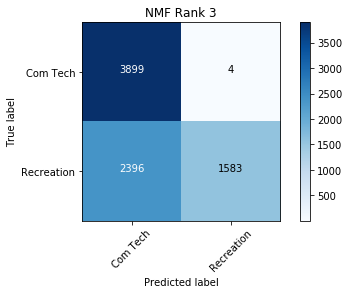

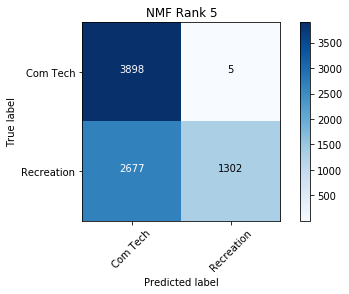

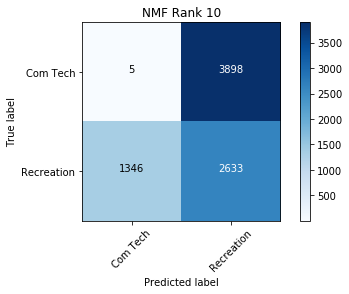

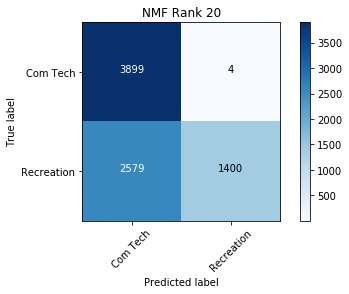

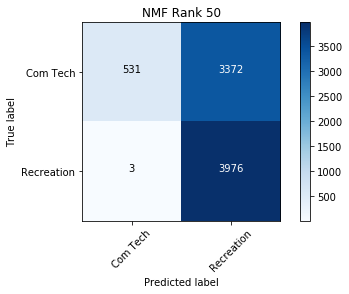

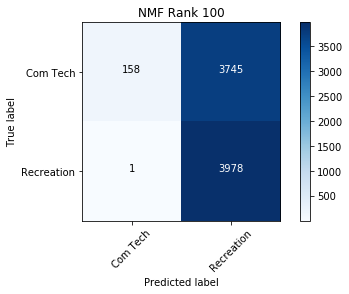

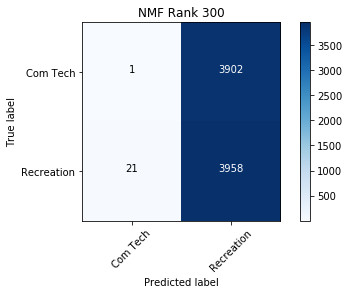

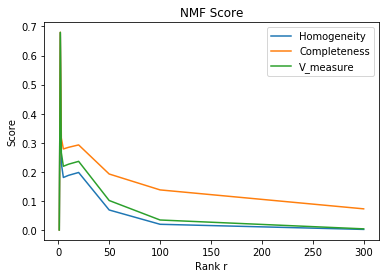

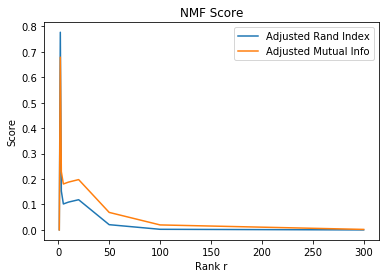

In [29]:
hg, cp, vm, ari, ami = prob_3a_ii('NMF')

In [30]:
print(hg)
print(cp)
print(vm)
print(ari)
print(ami)

[  2.84309864e-04   6.79048356e-01   2.29342703e-01   1.80630686e-01
   1.87877154e-01   1.97840623e-01   6.88427829e-02   1.96399683e-02
   2.01616661e-03]
[  2.88883632e-04   6.80131609e-01   3.16483957e-01   2.78708797e-01
   2.84253640e-01   2.92659919e-01   1.92571659e-01   1.37903896e-01
   7.27703603e-02]
[  2.86578500e-04   6.79589551e-01   2.65957277e-01   2.19198928e-01
   2.26228688e-01   2.36085450e-01   1.01426446e-01   3.43831625e-02
   3.92362573e-03]
[  3.17459615e-04   7.77017779e-01   1.52797450e-01   1.01955672e-01
   1.09214069e-01   1.18637723e-01   2.05267830e-02   2.35282545e-03
  -7.24958328e-05]
[  1.92785092e-04   6.79018973e-01   2.29272139e-01   1.80555657e-01
   1.87802790e-01   1.97767172e-01   6.87574710e-02   1.95499484e-02
   1.92259744e-03]


## Problem 4 (a). Visualize Best Clustering Results

In [55]:
def visualize_in_2D(method, data, bestR):
    reduced_data = data[:,:bestR]
    km = KMeans(n_clusters=2, max_iter=100, n_init=20)
    km.fit(reduced_data)
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=km.labels_)
    plt.title('KMeans clustering ('+str(method)+')')
    plt.show()

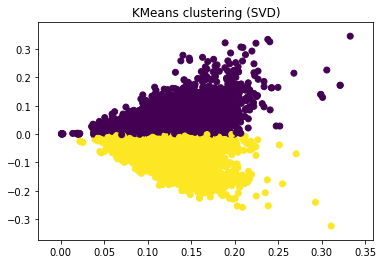

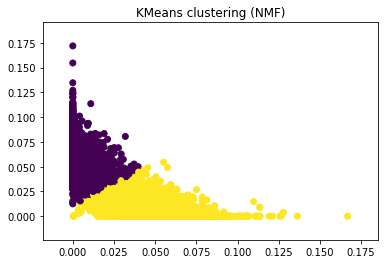

In [56]:
# 4(a)
best_SVD = 2
best_NMF = 2

# visualize SVD
visualize_in_2D('SVD', svd_X, best_SVD)

# visualize NMF
nmf = NMF(n_components=best_NMF)
nmf_X = nmf.fit_transform(TFIDF)
visualize_in_2D('NMF', nmf_X, best_NMF)

In [57]:
def print_5measures(label_true, label_pred):
    print("Homogeneity: %0.3f" % homogeneity_score(label_true, label_pred))
    print("Completeness: %0.3f" % completeness_score(label_true, label_pred))
    print("V-measure: %0.3f" % v_measure_score(label_true, label_pred))
    print("Adjusted rand score: %.3f" % adjusted_rand_score(label_true, label_pred))
    print("Adjusted mutual info score: %.3f" % adjusted_mutual_info_score(label_true, label_pred))

In [264]:
km = KMeans(n_clusters=2, max_iter=100, n_init=20)
km.fit(svd_X[:, :best_SVD])
print_5measures(eightLabels, km.labels_)
km.fit(nmf_X)
print_5measures(eightLabels, km.labels_)


Homogeneity: 0.596
Completeness: 0.597
V-measure: 0.596
Adjusted rand score: 0.699
Adjusted mutual info score: 0.596
Homogeneity: 0.679
Completeness: 0.680
V-measure: 0.680
Adjusted rand score: 0.777
Adjusted mutual info score: 0.679


## Problem 4 (b). Different Transformations

### Normalize

Homogeneity: 0.235
Completeness: 0.264
V-measure: 0.249
Adjusted rand score: 0.255
Adjusted mutual info score: 0.235


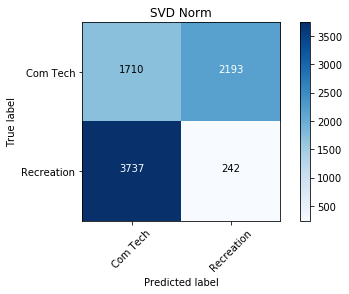

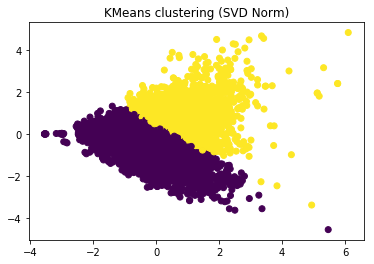

Homogeneity: 0.683
Completeness: 0.686
V-measure: 0.684
Adjusted rand score: 0.773
Adjusted mutual info score: 0.683


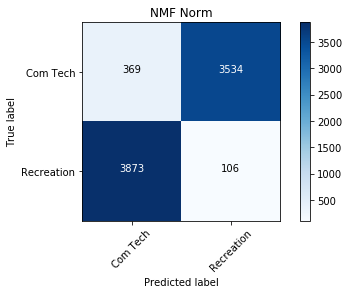

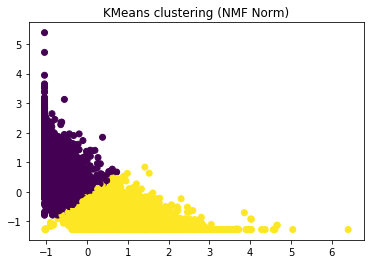

In [61]:
# problem 4b
# normalize features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
norm_svd = scaler.fit_transform(svd_X[:, :best_SVD])
norm_nmf = scaler.fit_transform(nmf_X)

km = KMeans(n_clusters=2, max_iter=100, n_init=20)
km.fit(norm_svd)
print_5measures(eightLabels, km.labels_)
title = 'SVD Norm'
plot_contingency_matrix(eightLabels, km.labels_, class_names, title=title)
visualize_in_2D('SVD Norm', norm_svd, best_SVD)

km.fit(norm_nmf)
print_5measures(eightLabels, km.labels_)
title = 'NMF Norm'
plot_contingency_matrix(eightLabels, km.labels_, class_names, title=title)
visualize_in_2D('NMF Norm', norm_nmf, best_NMF)


### Log Tranformation

Homogeneity: 0.712
Completeness: 0.712
V-measure: 0.712
Adjusted rand score: 0.808
Adjusted mutual info score: 0.712


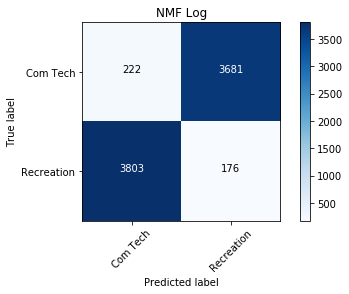

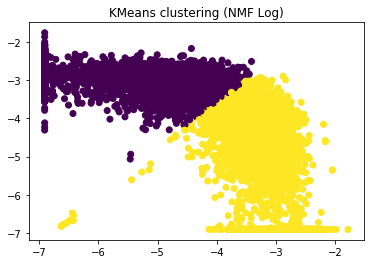

In [73]:
# log
log_nmf = np.log(nmf_X+0.001)
km.fit(log_nmf)
print_5measures(eightLabels, km.labels_)
title = 'NMF Log'
plot_contingency_matrix(eightLabels, km.labels_, class_names, title=title)
visualize_in_2D('NMF Log', log_nmf, best_NMF)

### Norm and then Log

Homogeneity: 0.663
Completeness: 0.667
V-measure: 0.665
Adjusted rand score: 0.751
Adjusted mutual info score: 0.663


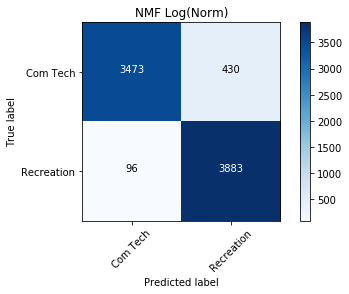

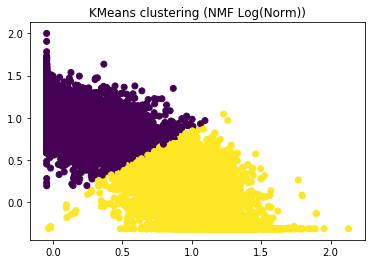

In [76]:
# log_norm
log_norm_nmf = np.log(norm_nmf+2.001)
km.fit(log_norm_nmf)
print_5measures(eightLabels, km.labels_)
title = 'NMF Log(Norm)'
plot_contingency_matrix(eightLabels, km.labels_, class_names, title=title)
visualize_in_2D('NMF Log(Norm)', log_norm_nmf, best_NMF)

### Log and then Norm

Homogeneity: 0.711
Completeness: 0.712
V-measure: 0.712
Adjusted rand score: 0.806
Adjusted mutual info score: 0.711


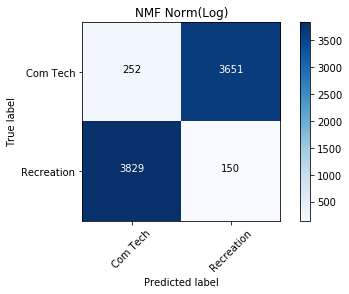

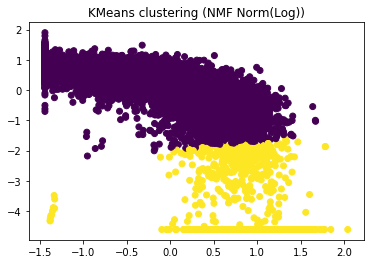

In [72]:
# norm_log
norm_log_nmf = scaler.fit_transform(log_nmf)
km.fit(norm_log_nmf)
print_5measures(eightLabels, km.labels_)
title = 'NMF Norm(Log)'
plot_contingency_matrix(eightLabels, km.labels_, class_names, title=title)
visualize_in_2D('NMF Norm(Log)', log_norm_nmf, best_NMF)

## Problem 5. Expand Dataset into 20 categories

In [78]:
# problem 5
twentyData = fetch_20newsgroups(subset='all')
TFIDF20 = pipe.fit_transform(twentyData.data)
print("p5: dimension of the TF-IDF matrix is: ", TFIDF20.shape)

p5: dimension of the TF-IDF matrix is:  (18846, 52295)


### Apply K-means clustering with k = 20 using the TF-IDF data

In [104]:
km20 = KMeans(n_clusters=20, max_iter=50, n_init = 10)
km20.fit(TFIDF20)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
    n_clusters=20, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

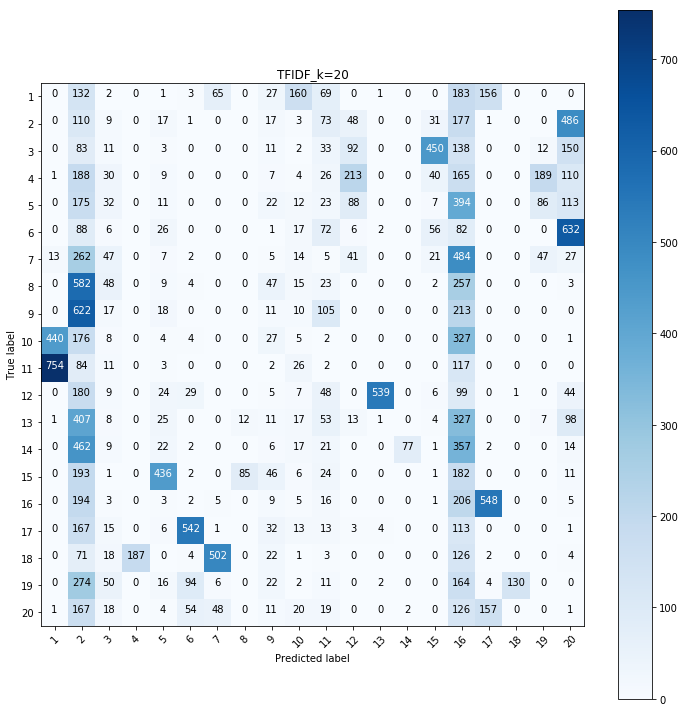

In [205]:
twentyLabels = [x for x in twentyData.target]
classnames = np.array([])
for i in range(1, 21):
    classnames = np.append(classnames, str(i))
title = 'TFIDF_k=20'
plot_contingency_matrix(twentyLabels, km20.labels_, classnames, normalize=False, title=title, fs=10)

In [178]:
print_5measures(twentyLabels, km20.labels_)

Homogeneity: 0.322
Completeness: 0.398
V-measure: 0.356
Adjusted rand score: 0.119
Adjusted mutual info score: 0.320


### Dimension Reduction (SVD)

In [179]:
rank = 1000
svd = TruncatedSVD(n_components=rank)
svd_20 = svd.fit_transform(TFIDF20)

In [246]:
def prob5(method, XData=None, tfidf=None):
#     ranks = np.array([1,2,3,5,10,20,50,100,300])
    ranks = np.array(range(1,21))
    np_hg = np.array([])
    np_cp = np.array([])
    np_vm = np.array([])
    np_ari = np.array([])
    np_ami = np.array([])
    classnames = np.array([])
    for i in range(1, 21):
        classnames = np.append(classnames, str(i))

    for r in ranks:
        if method == 'NMF':
            nmf = NMF(n_components=r, max_iter=(50 if r==300 else 200))
            data = nmf.fit_transform(tfidf)
        else:
            data = XData[:,:r]
        km = KMeans(n_clusters=20, max_iter=500, n_init=100)
        km.fit(data)

        title = str(method)+' Rank '+str(r)
        plot_contingency_matrix(twentyLabels, km.labels_, classnames, 
                               normalize=False, title=title, fs=10)

        np_hg = np.append(np_hg, homogeneity_score(twentyLabels, km.labels_))
        np_cp = np.append(np_cp, completeness_score(twentyLabels, km.labels_))
        np_vm = np.append(np_vm, v_measure_score(twentyLabels, km.labels_))
        np_ari = np.append(np_ari, adjusted_rand_score(twentyLabels, km.labels_))
        np_ami = np.append(np_ami, adjusted_mutual_info_score(twentyLabels, km.labels_))

    x = ranks
    ys = [[np_hg, 'Homogeneity'],[np_cp, 'Completeness'], [np_vm, 'V_measure']]
    xlabel = 'Rank r'
    ylabel = 'Score'
    title = str(method)+' Score'
    make_plot(x, ys, xlabel, ylabel, title=title)
    ys = [[np_ari, 'Adjusted Rand Index'], [np_ami, 'Adjusted Mutual Info']]
    make_plot(x, ys, xlabel, ylabel, title=title)
    return np_hg, np_cp, np_vm, np_ari, np_ami

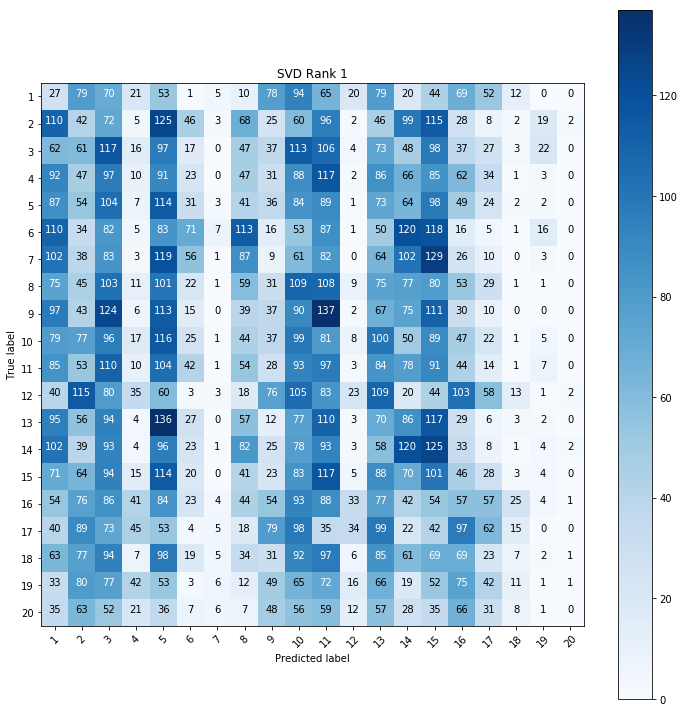

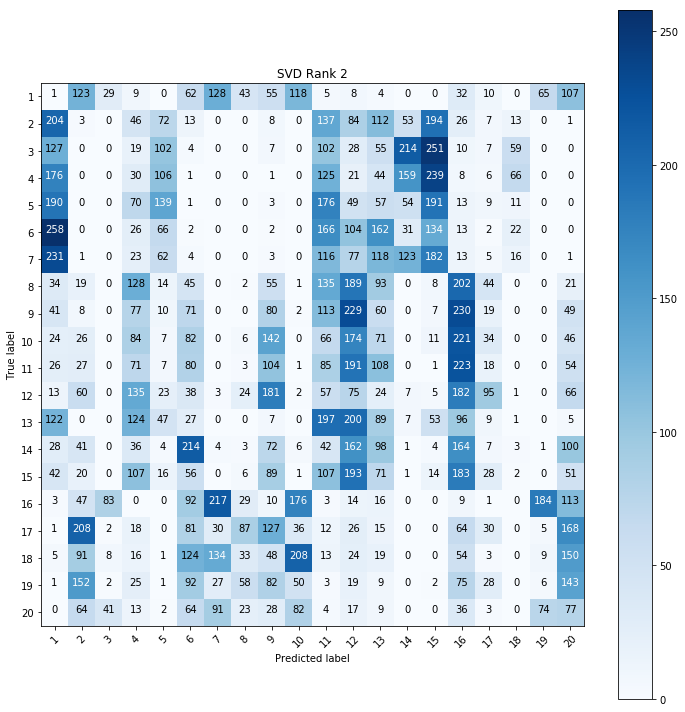

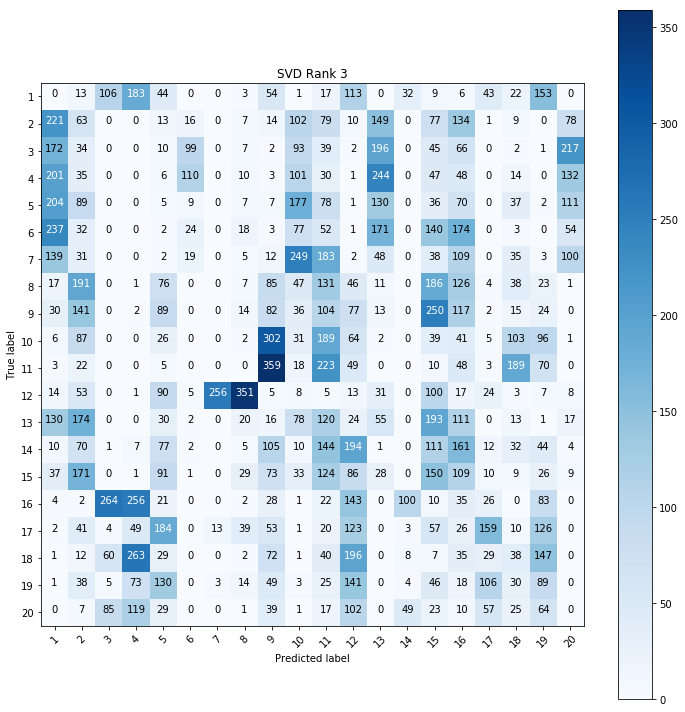

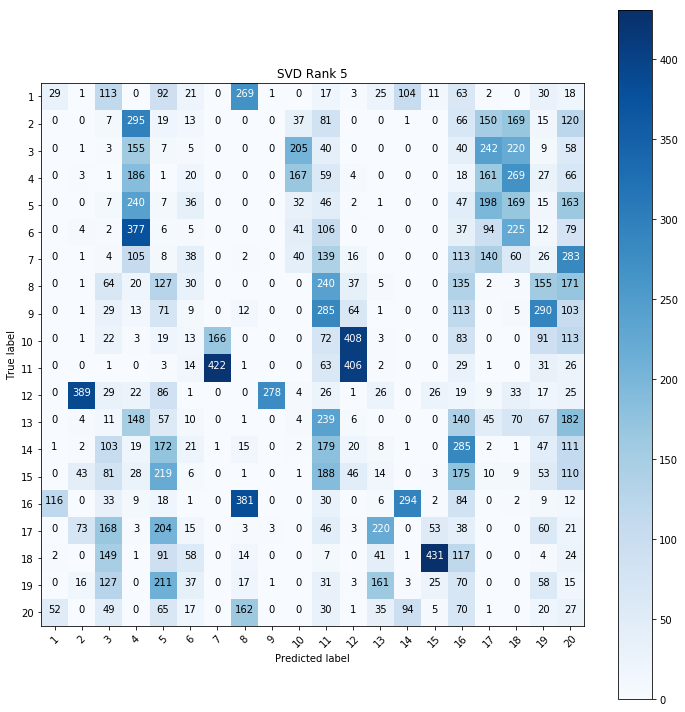

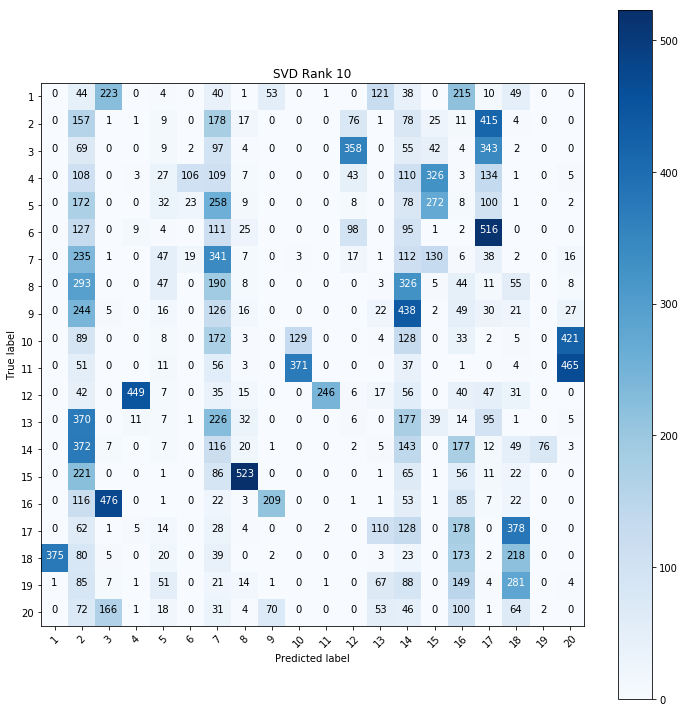

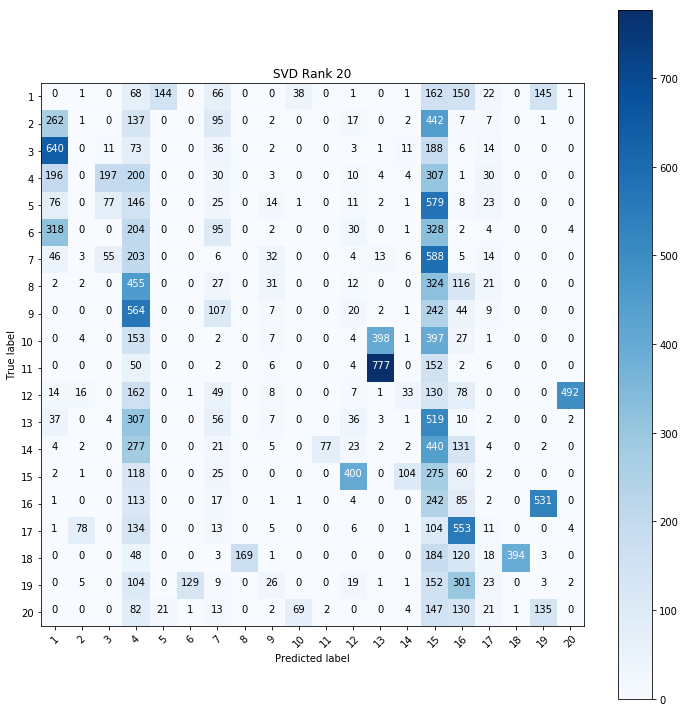

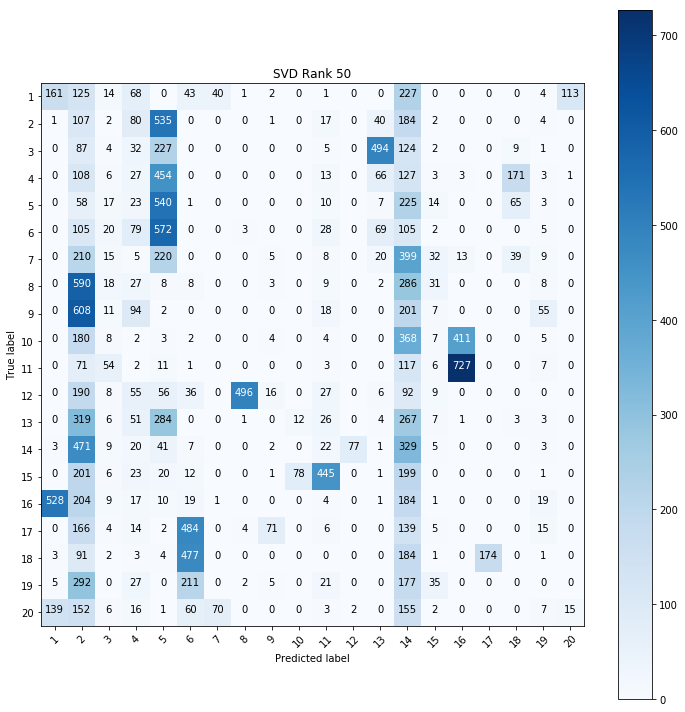

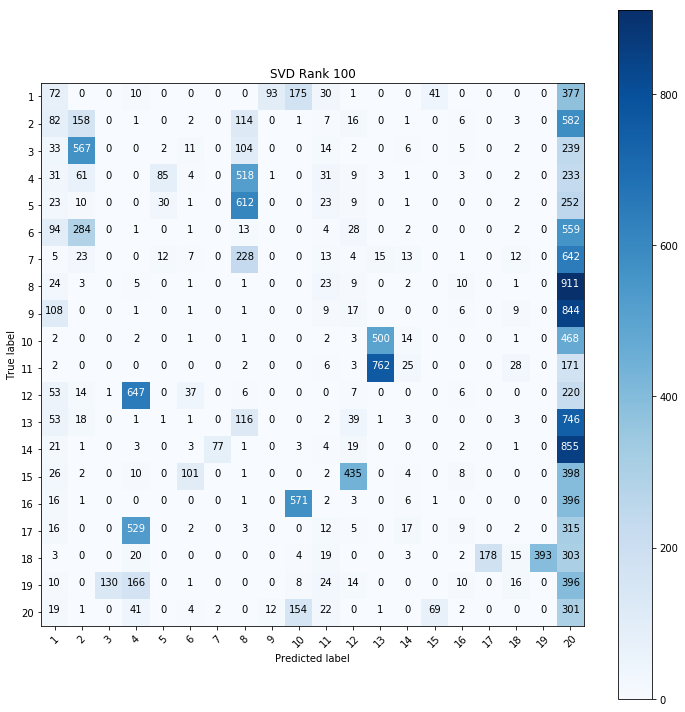

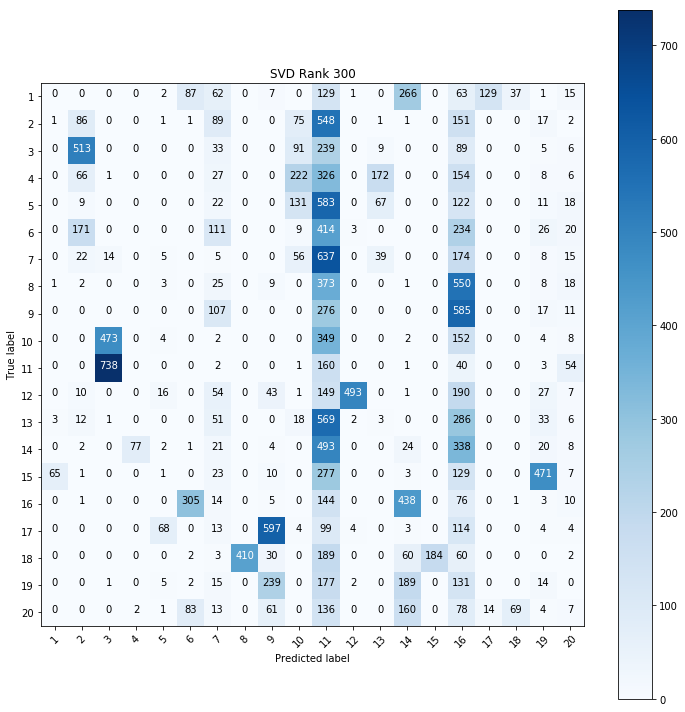

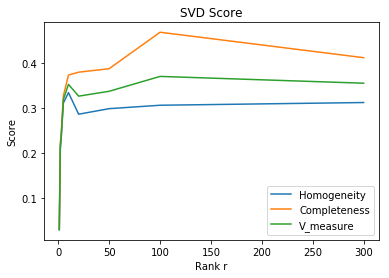

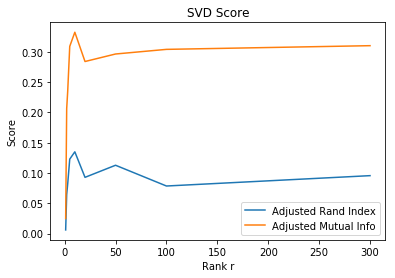

In [226]:
# ranks = np.array([1,2,3,5,10,20,50,100,300])
hg, cp, vm, ari, ami = prob5('SVD', svd_20)

In [227]:
print(np.argmax(ami))
print(ami)
print(ami[8])

4
[ 0.02476506  0.20639042  0.23506558  0.30923341  0.33255526  0.28420704
  0.29661298  0.30426415  0.31035878]
0.310358775762


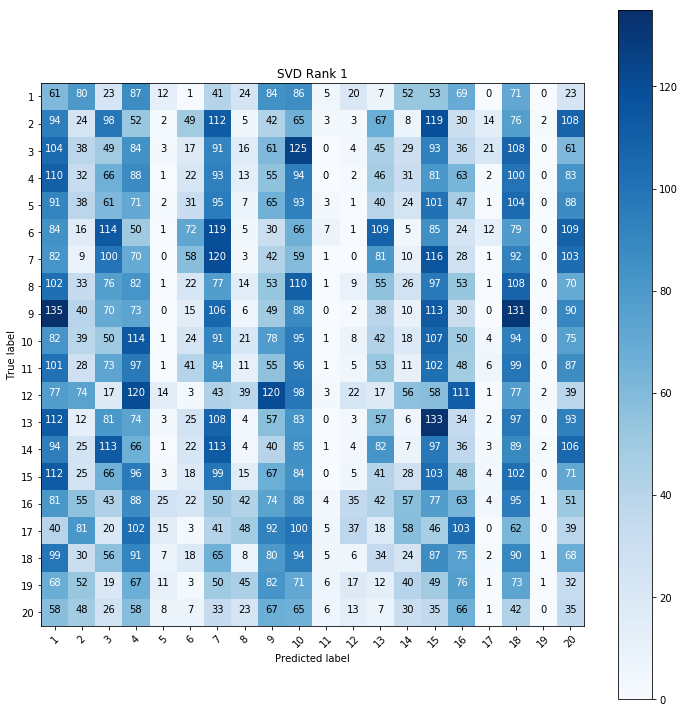

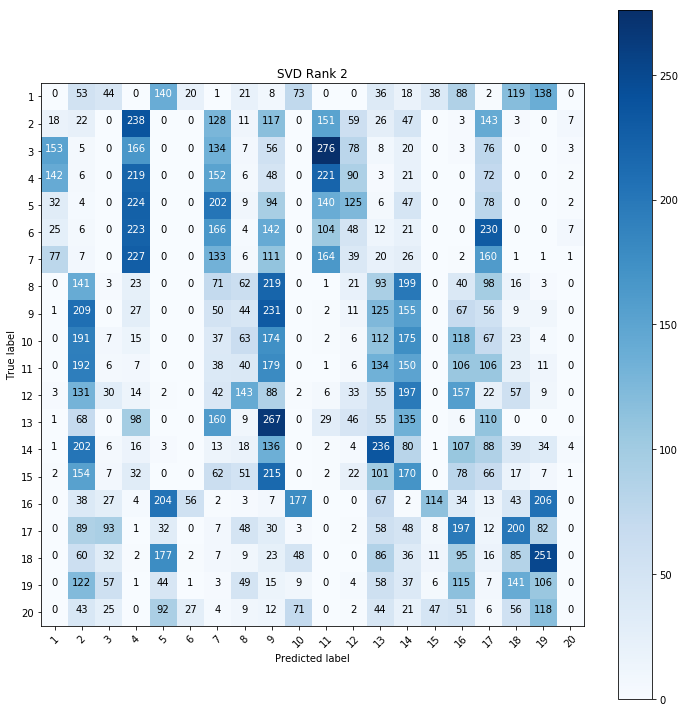

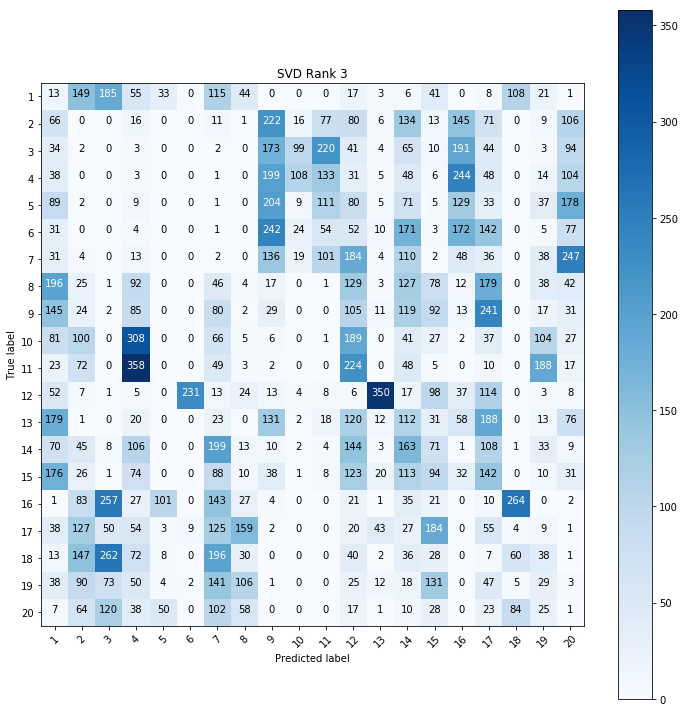

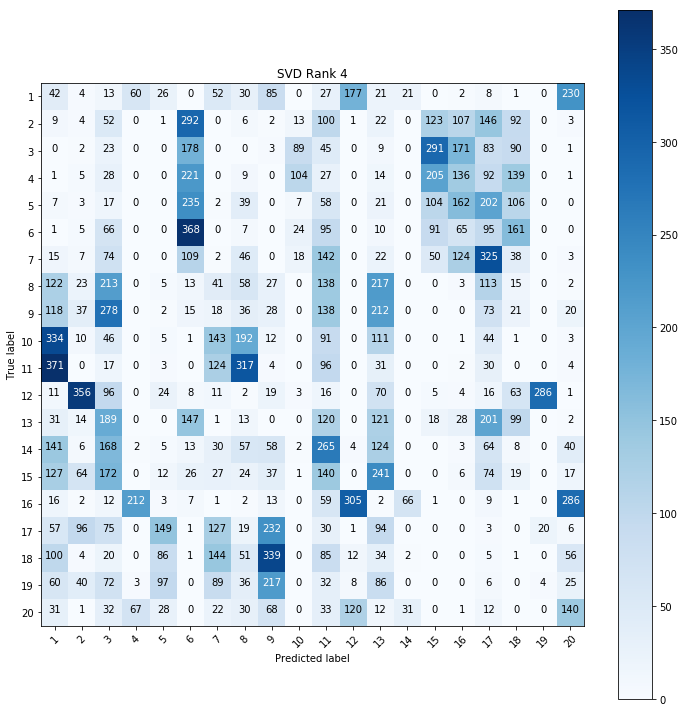

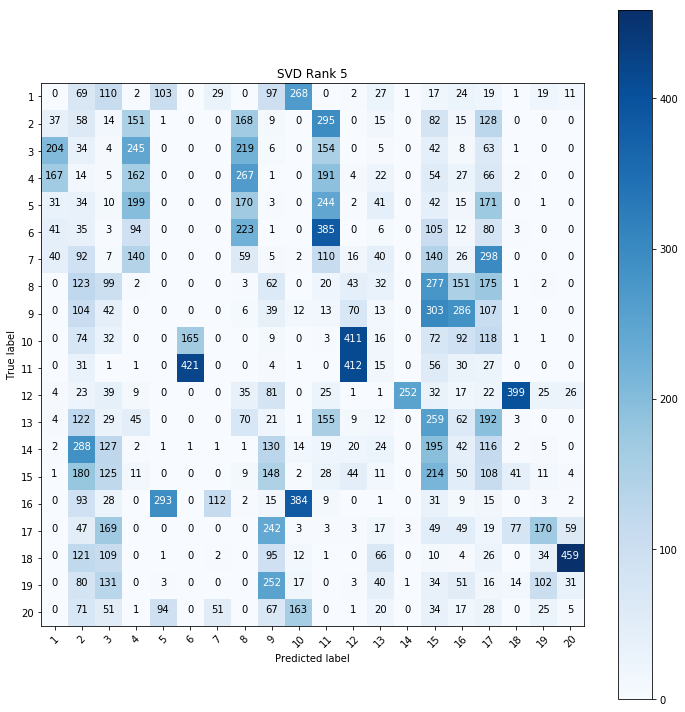

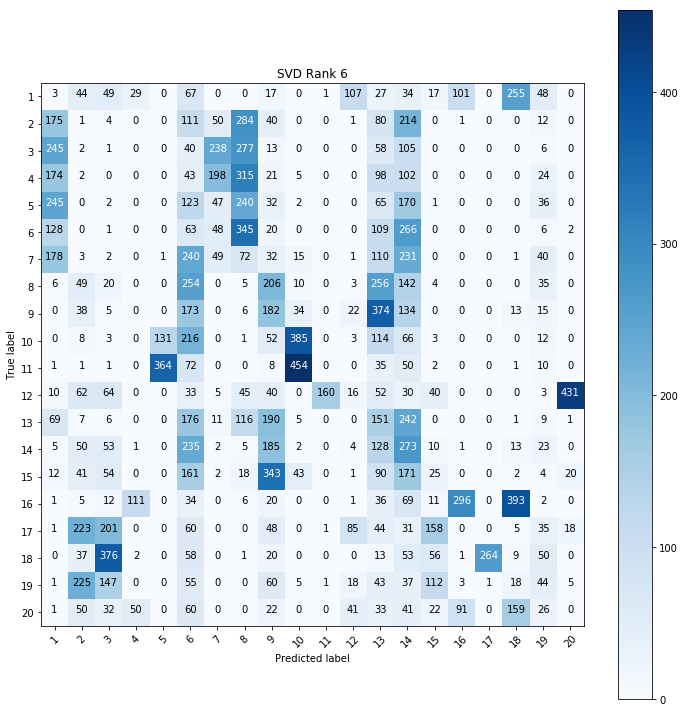

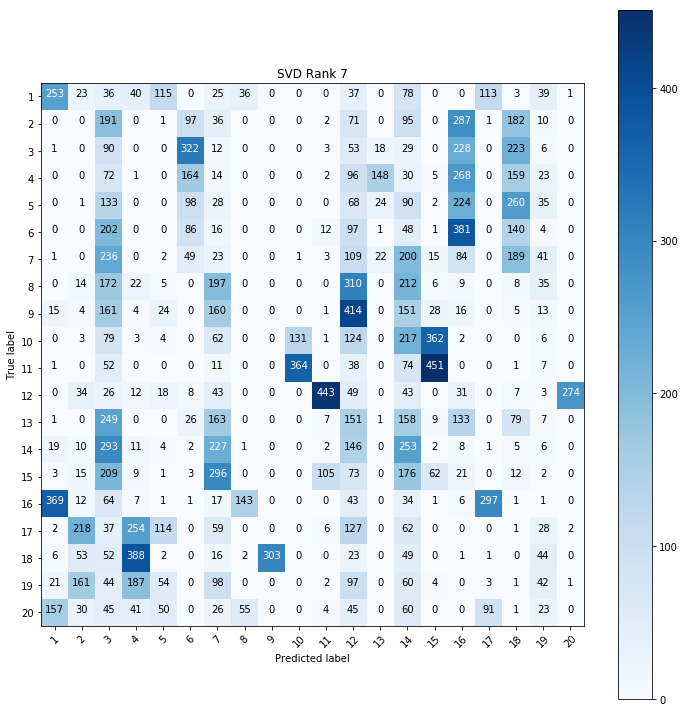

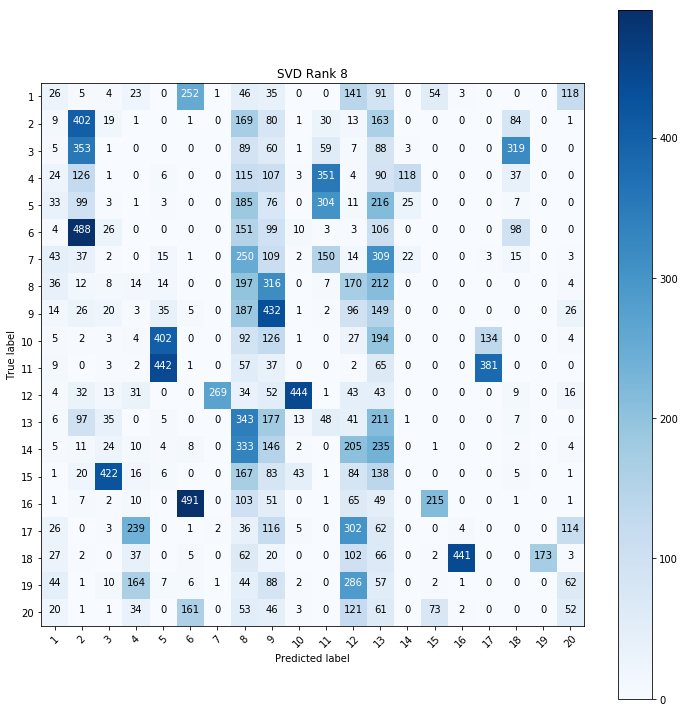

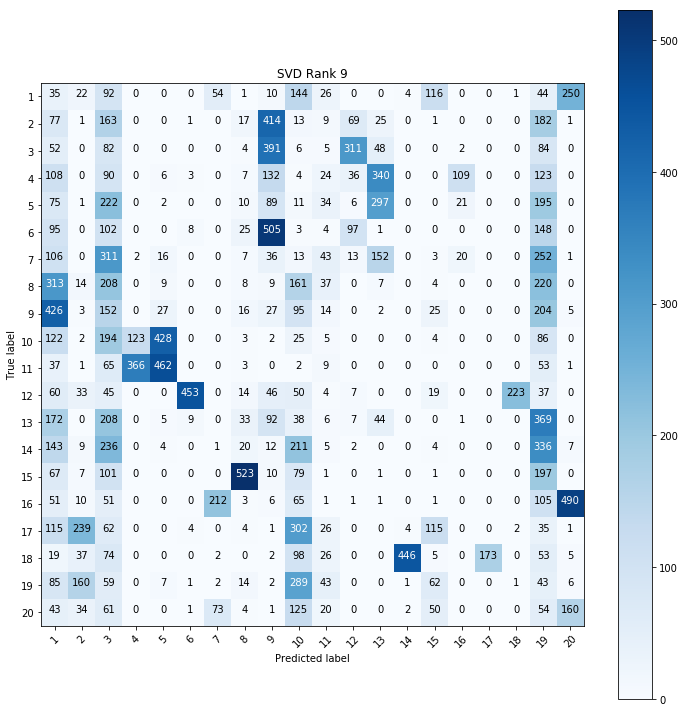

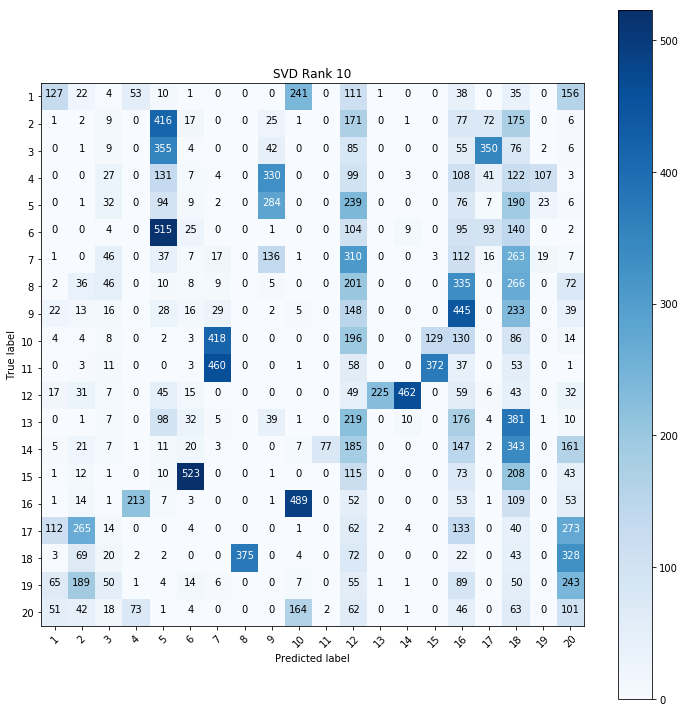

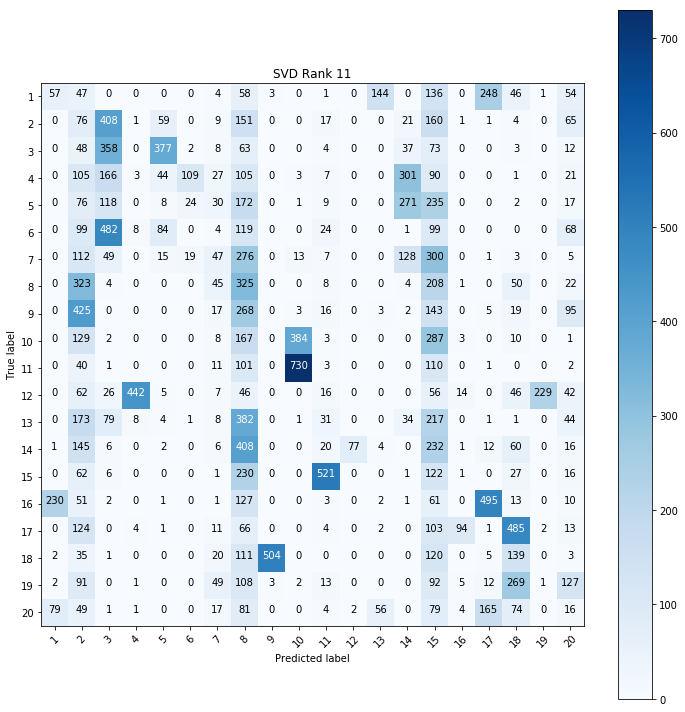

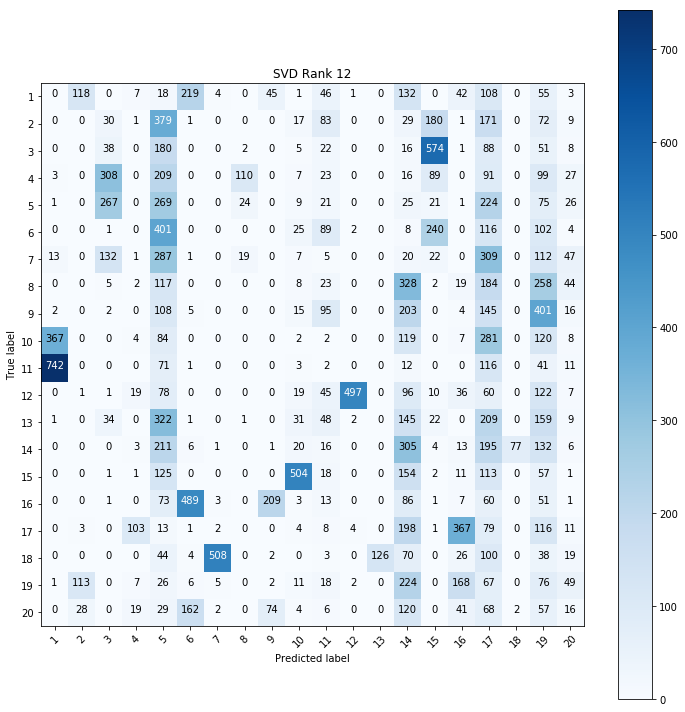

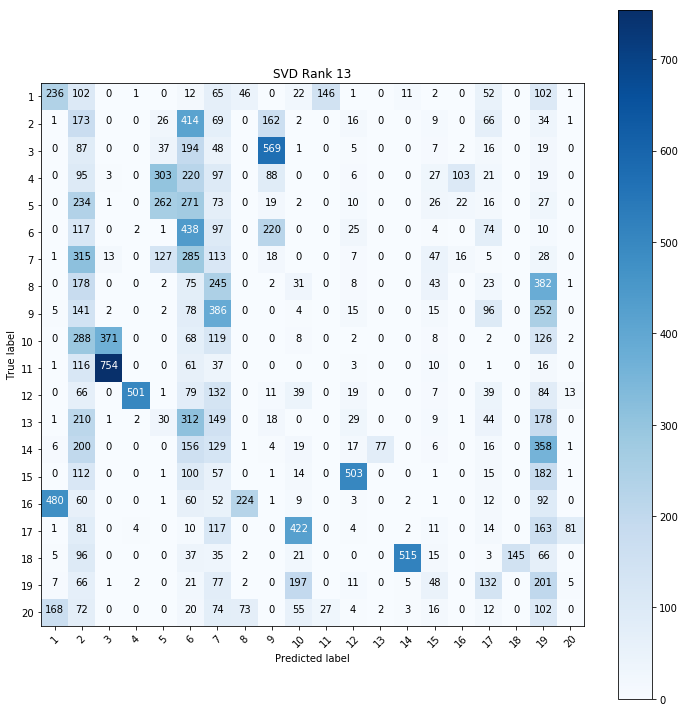

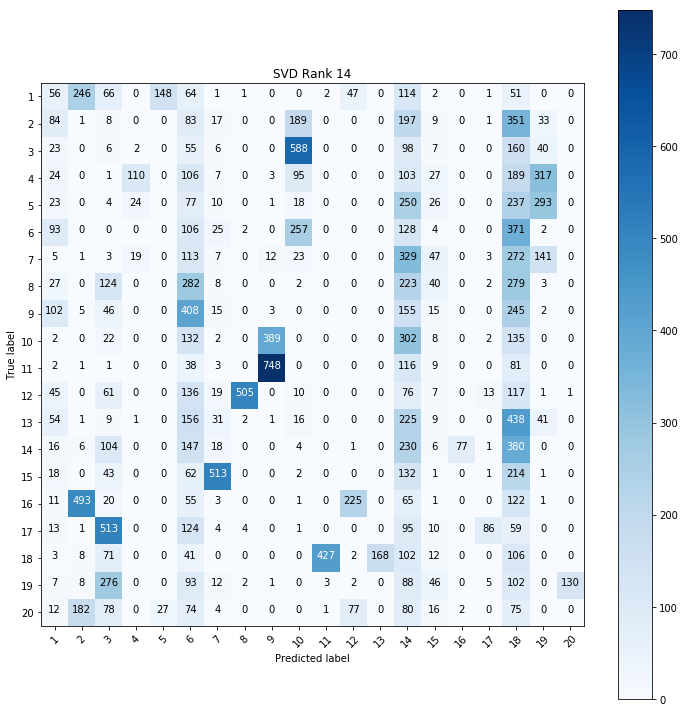

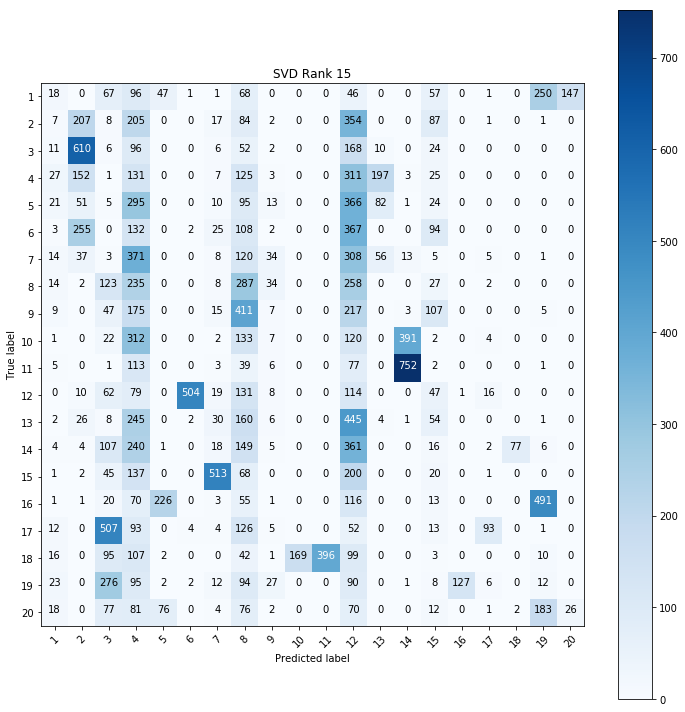

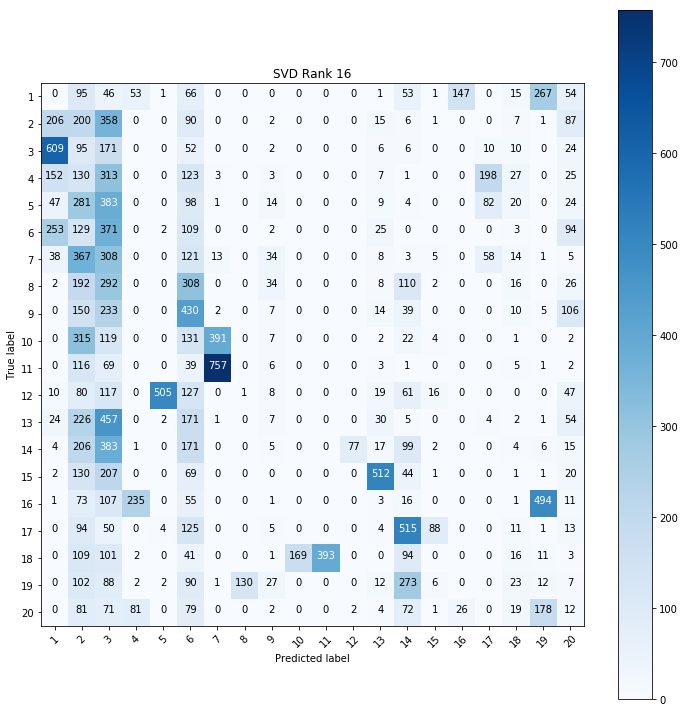

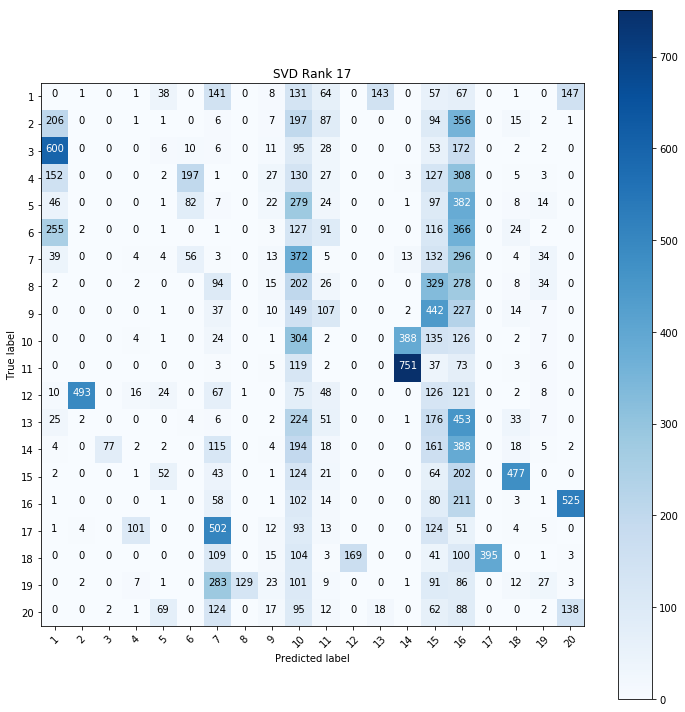

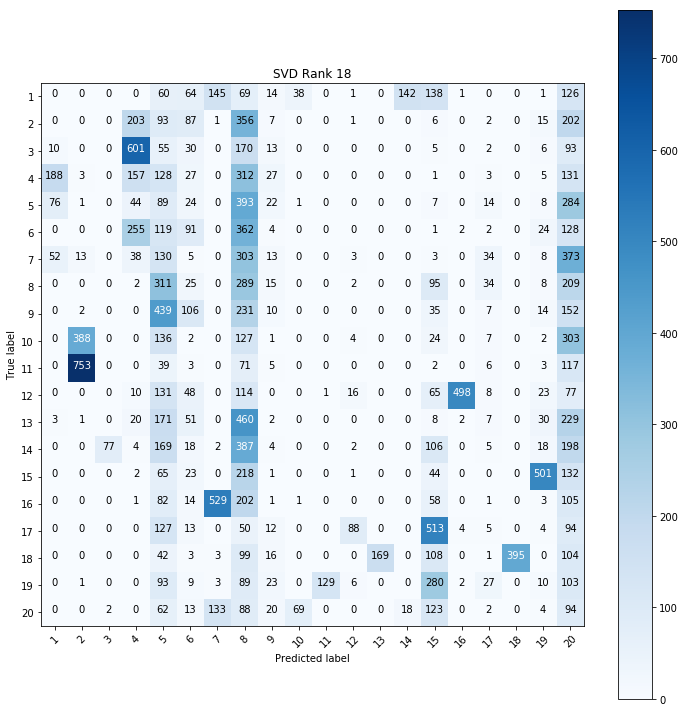

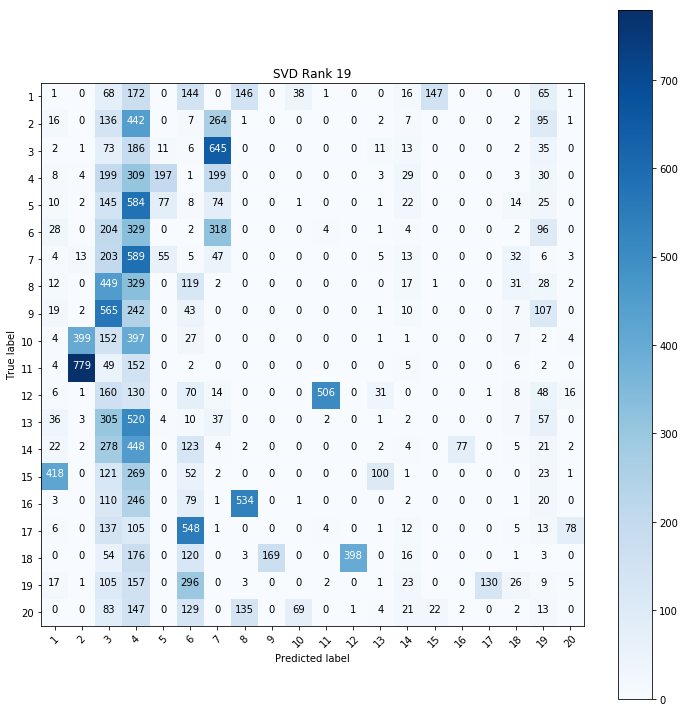

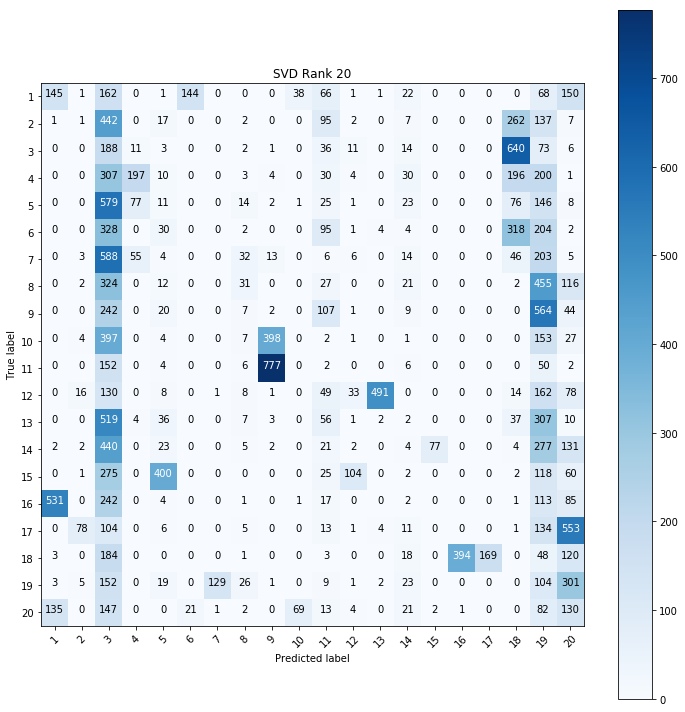

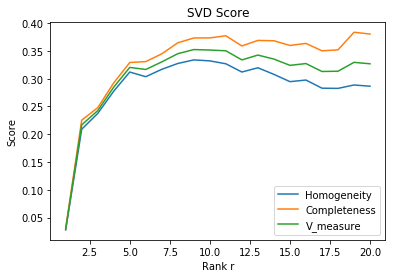

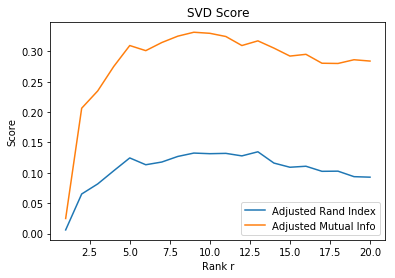

In [247]:
# ranks = np.array(range(1,21))
hg, cp, vm, ari, ami = prob5('SVD', svd_20)

In [249]:
print(np.argmax(ari))
print(ami)

12
[ 0.02472315  0.20644681  0.23492361  0.27518615  0.30973274  0.30130372
  0.31465876  0.32518057  0.33162575  0.32988058  0.32459552  0.30972788
  0.31742615  0.30550215  0.29234989  0.29524779  0.28055307  0.28018177
  0.28632088  0.28412914]


### Dimension Reduction (NMF)

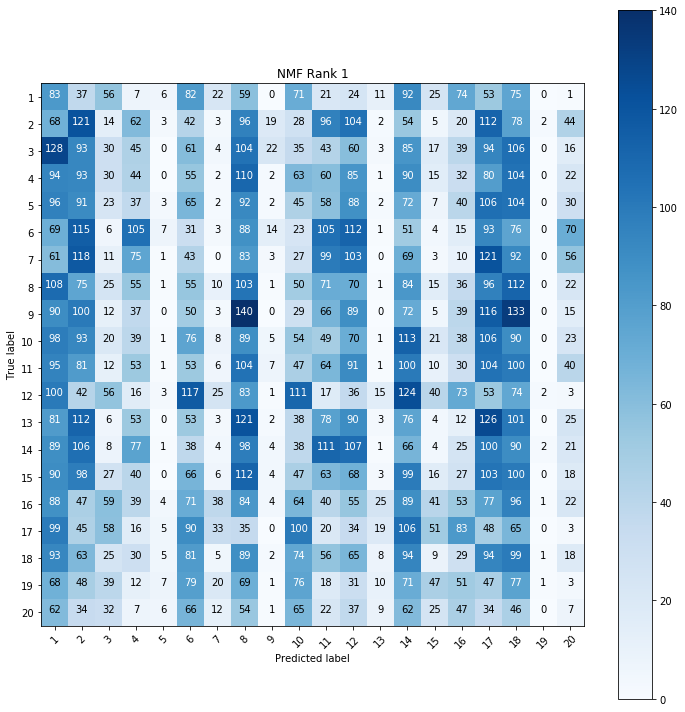

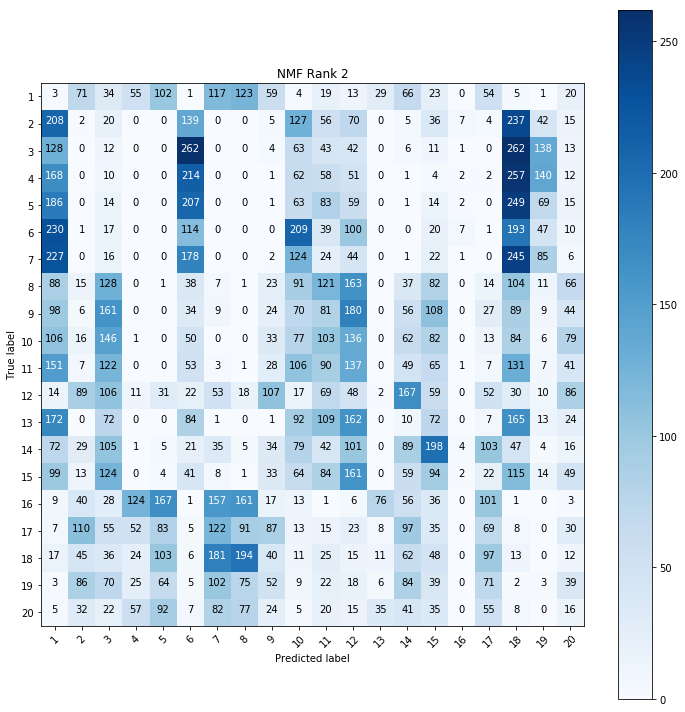

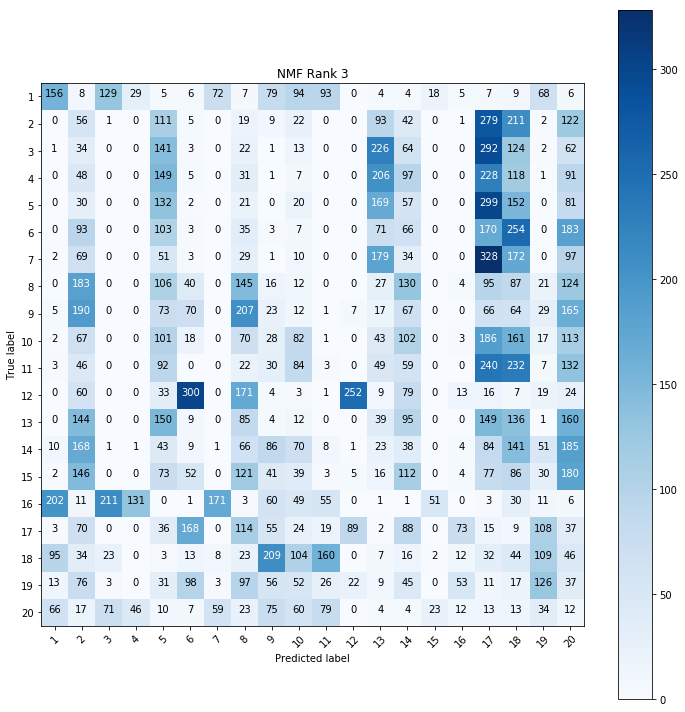

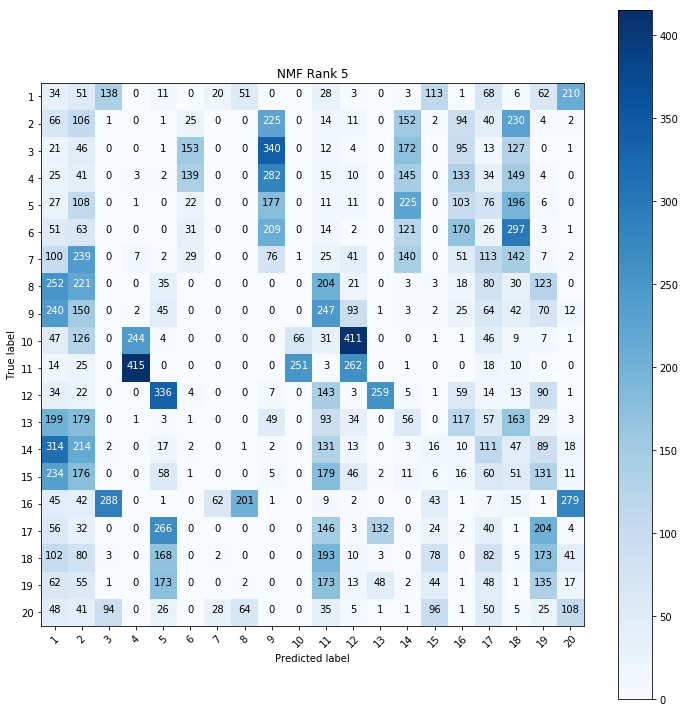

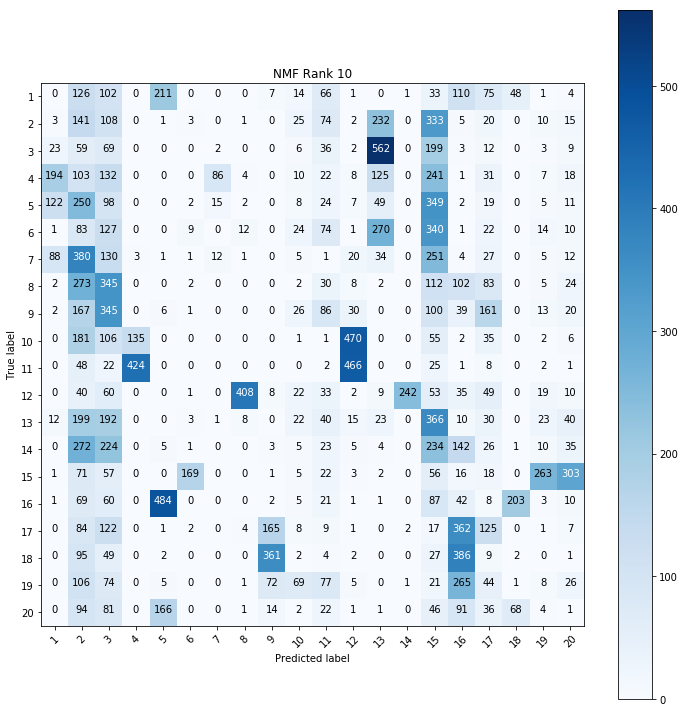

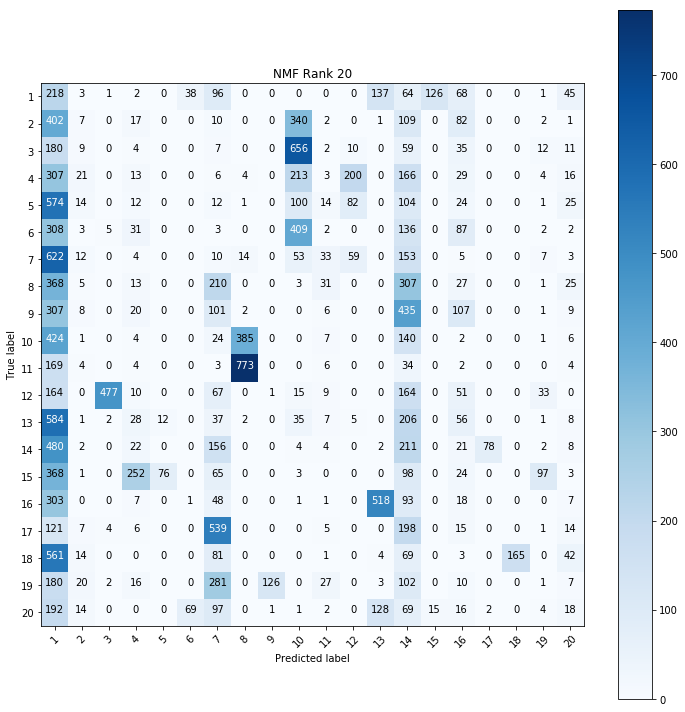

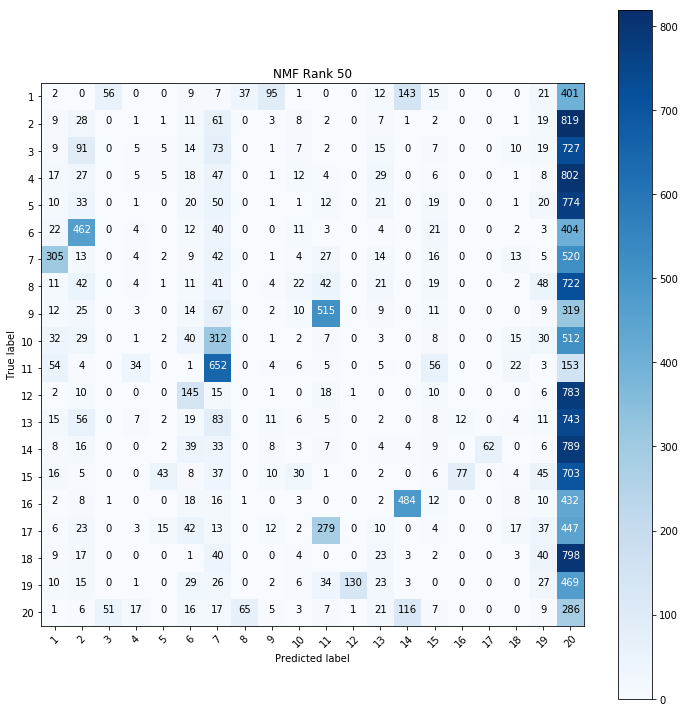

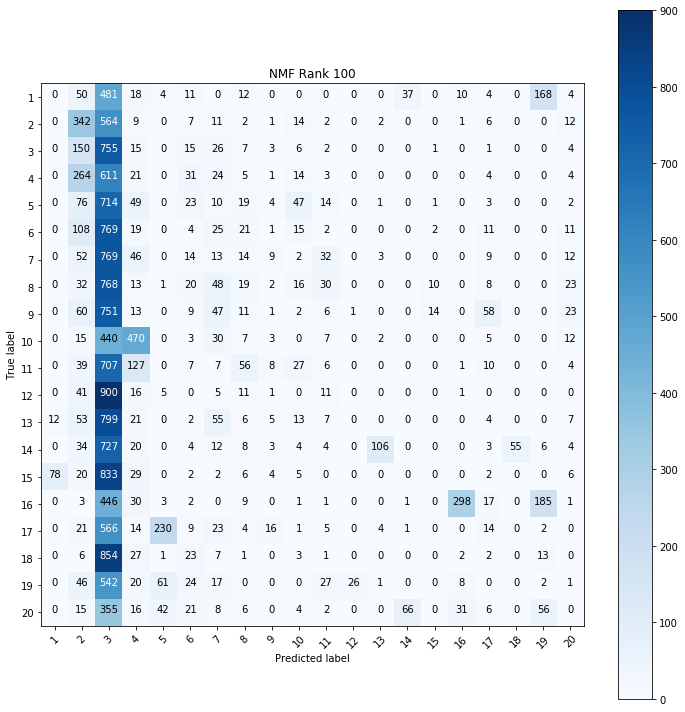

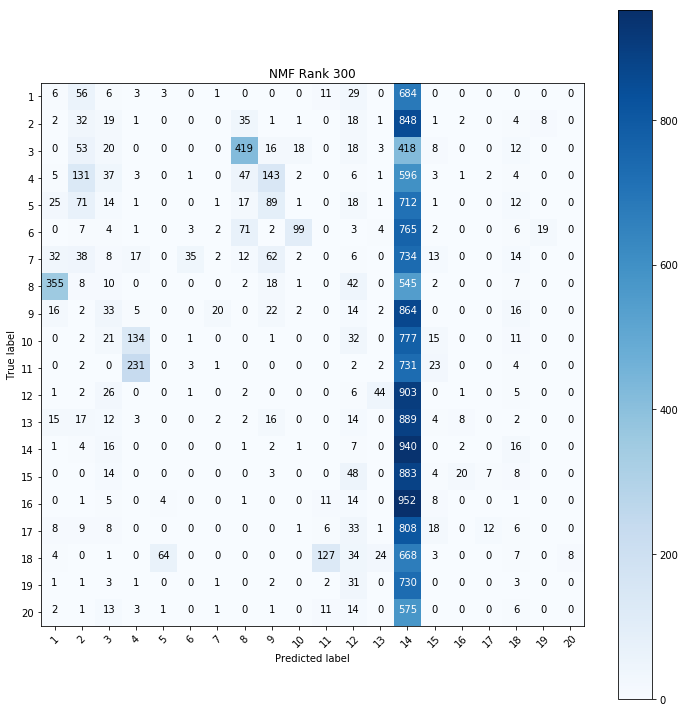

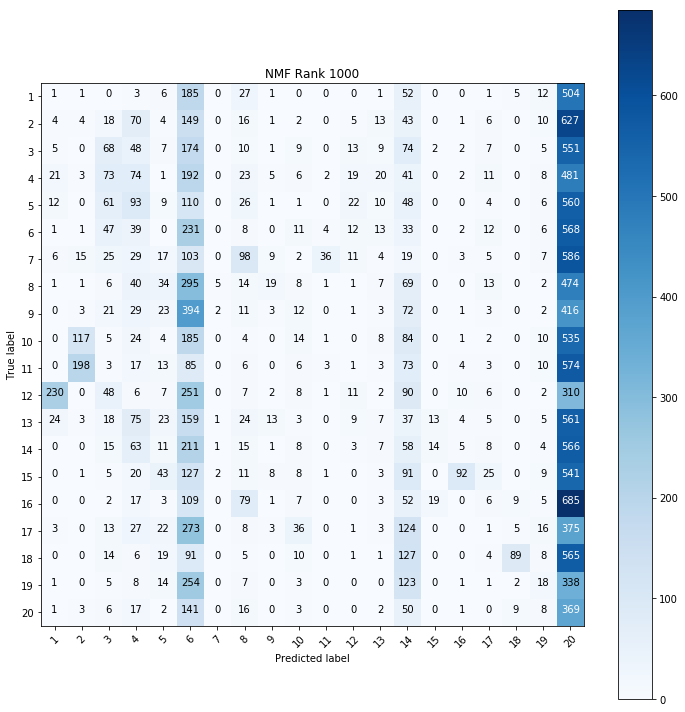

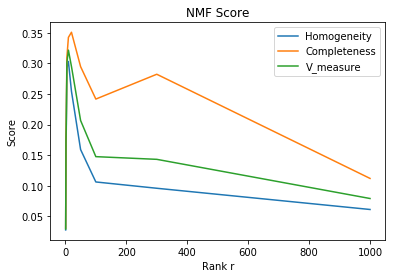

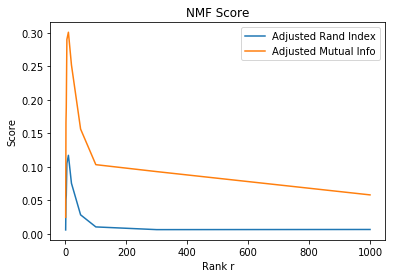

(array([ 0.02789472,  0.16886353,  0.19157371,  0.2923652 ,  0.30310171,
         0.25444285,  0.15915891,  0.10623746,  0.09594271,  0.06126395]),
 array([ 0.03089455,  0.17969861,  0.20881052,  0.30995667,  0.34240982,
         0.35081883,  0.29463471,  0.2416514 ,  0.28219485,  0.11202286]),
 array([ 0.0293181 ,  0.17411267,  0.19982108,  0.30090404,  0.32155894,
         0.29495785,  0.2066743 ,  0.14758985,  0.14319941,  0.0792093 ]),
 array([ 0.00585978,  0.05096276,  0.05726815,  0.10505601,  0.11719367,
         0.07541792,  0.02835633,  0.01033762,  0.00628759,  0.00651042]),
 array([ 0.02472482,  0.16615388,  0.18895157,  0.2900745 ,  0.30084184,
         0.25199651,  0.15637409,  0.10323233,  0.09286792,  0.0581362 ]))

In [203]:
# ranks = np.array([1,2,3,5,10,20,50,100,300])
prob5('NMF', tfidf=TFIDF20)

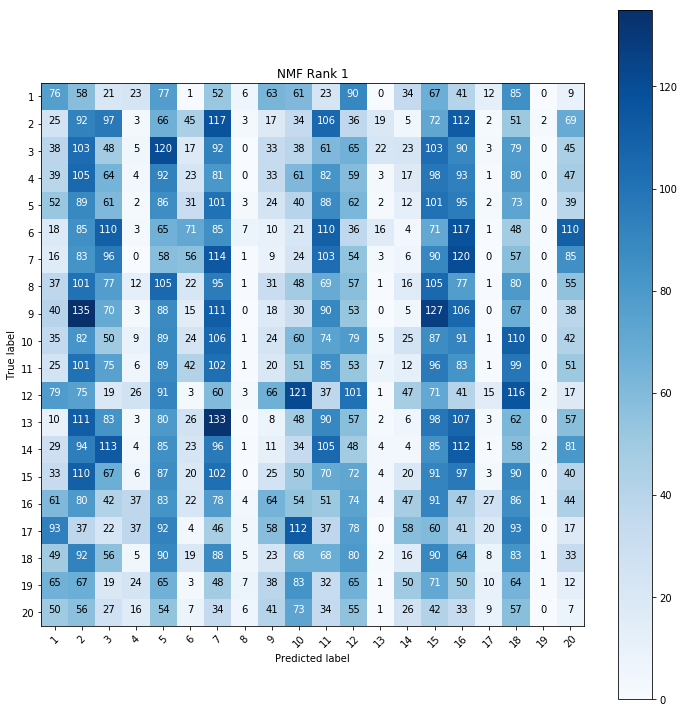

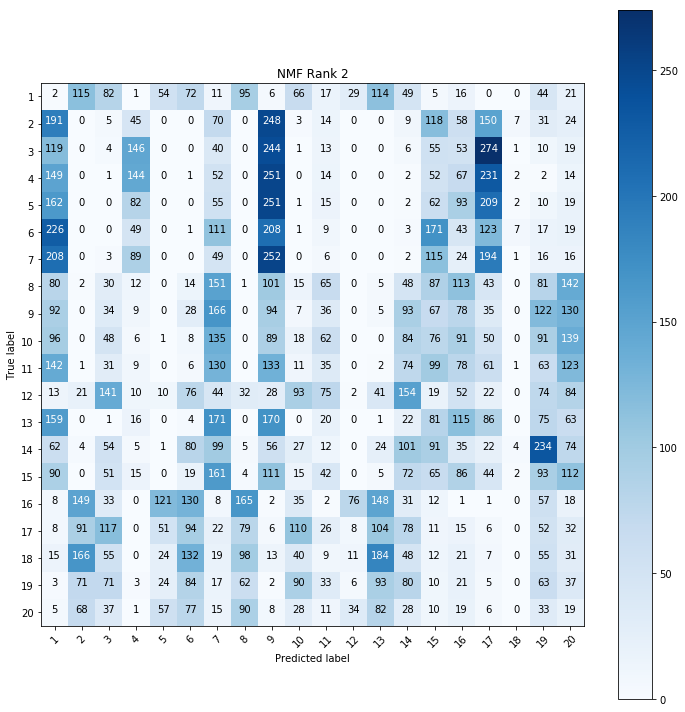

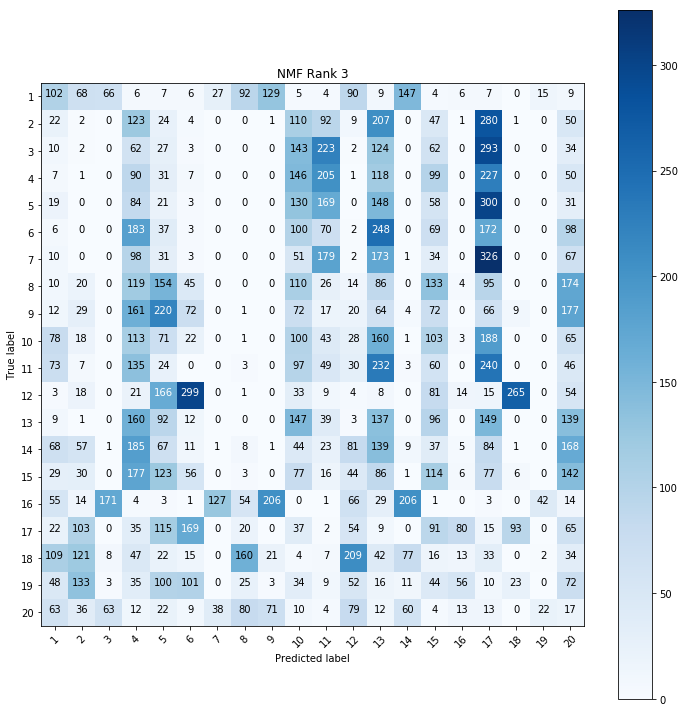

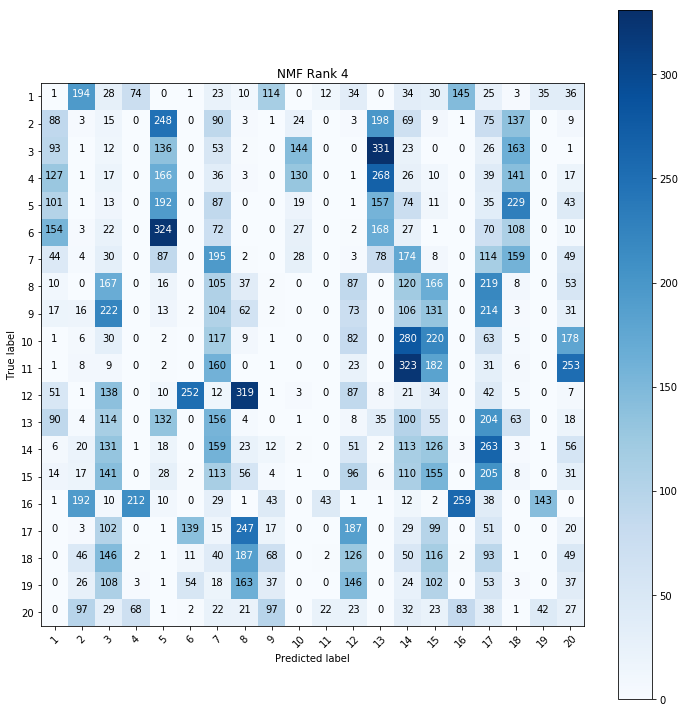

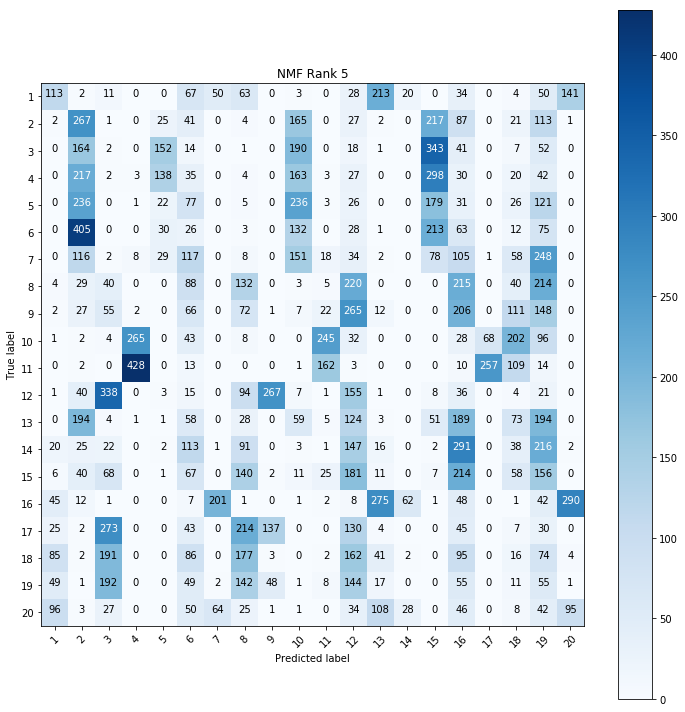

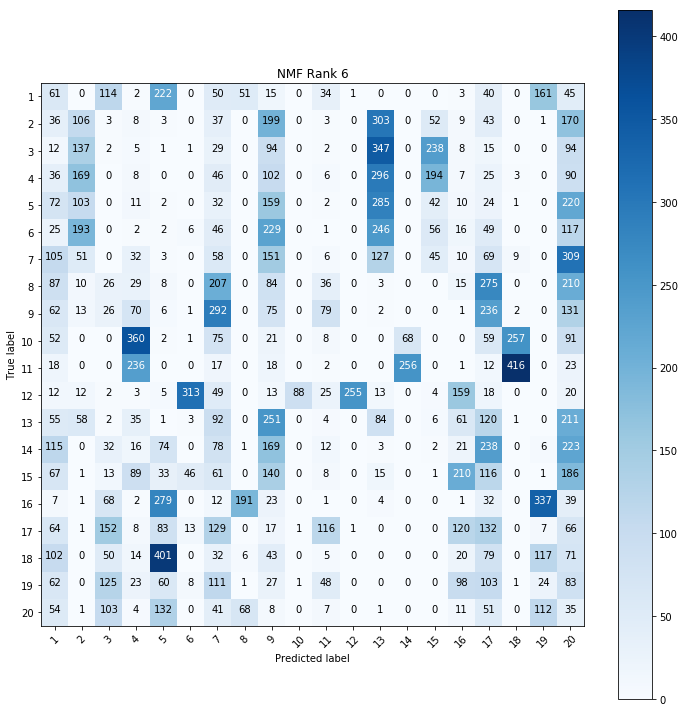

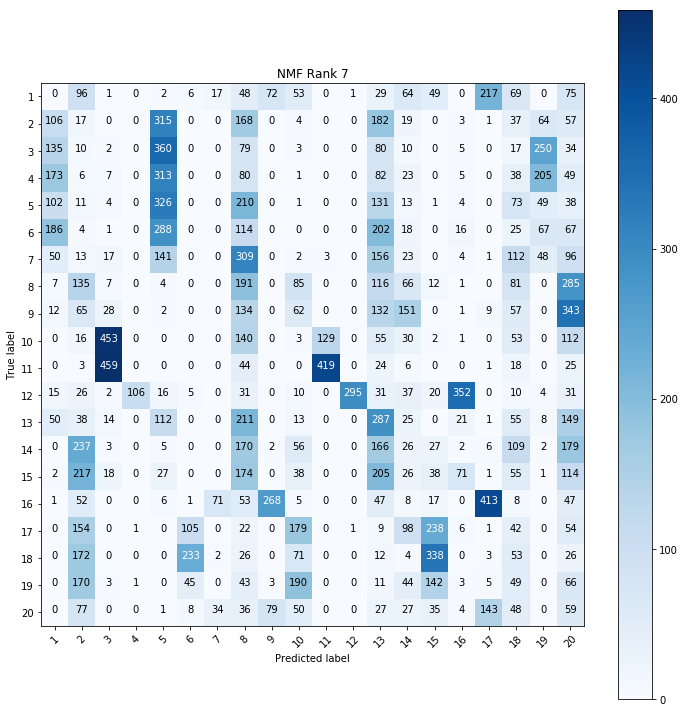

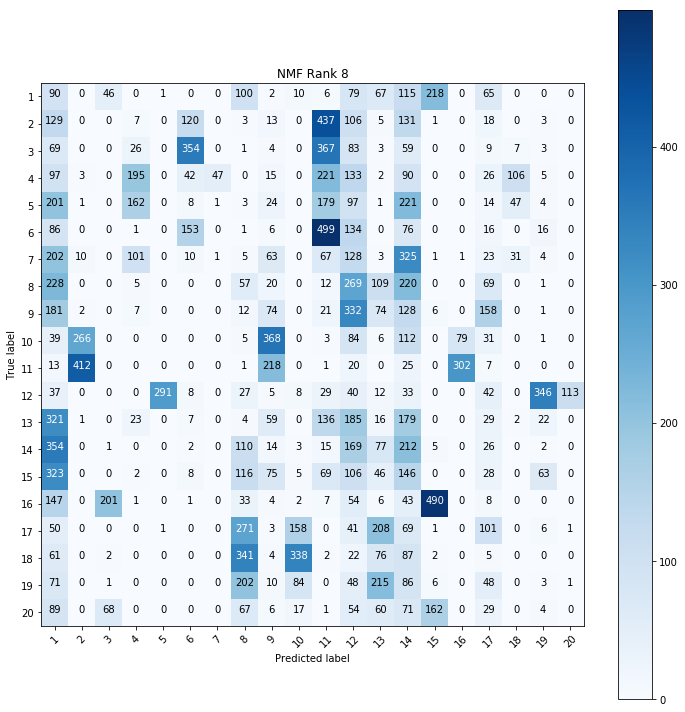

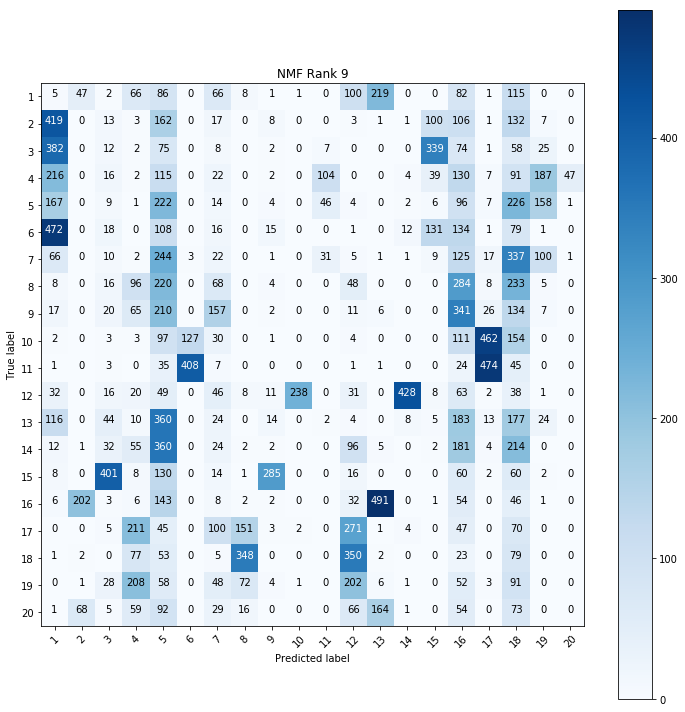

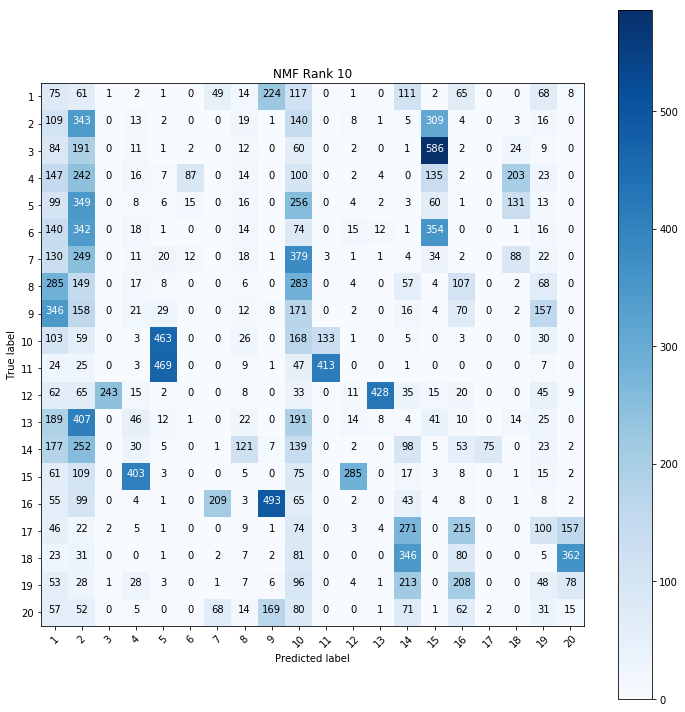

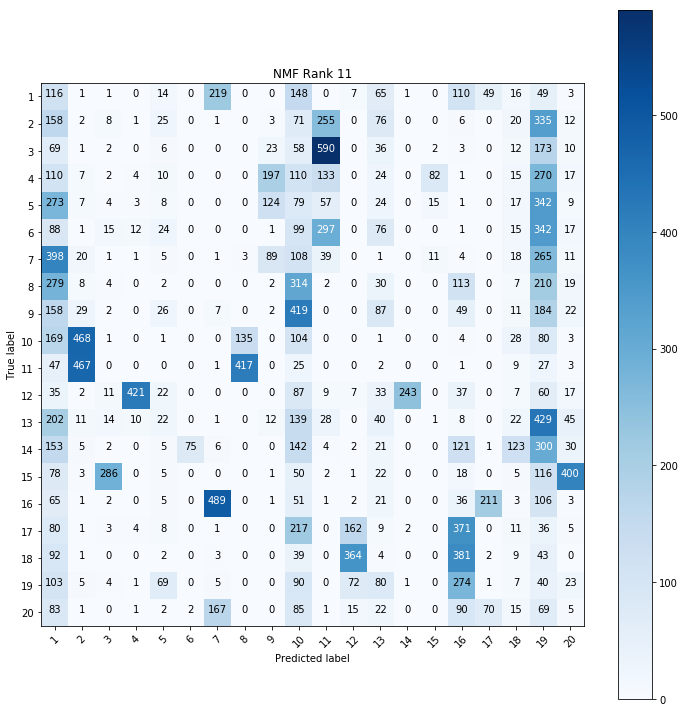

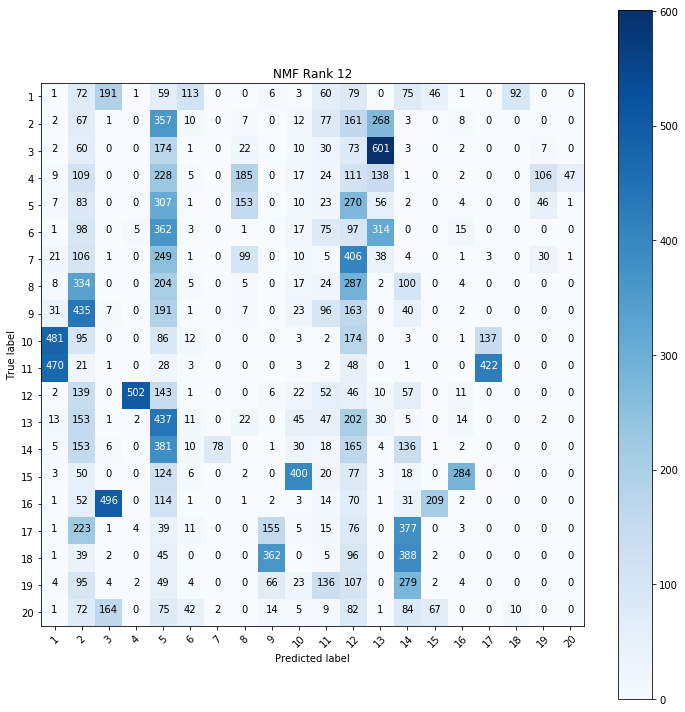

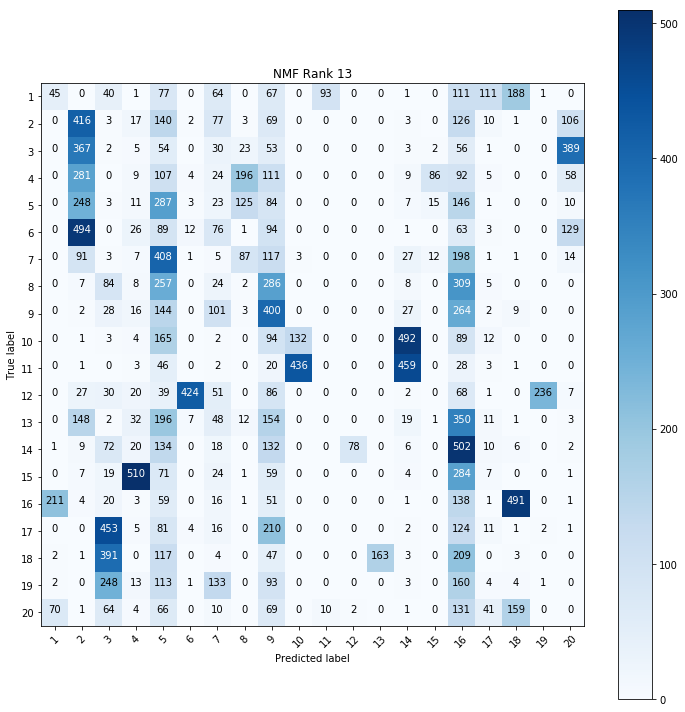

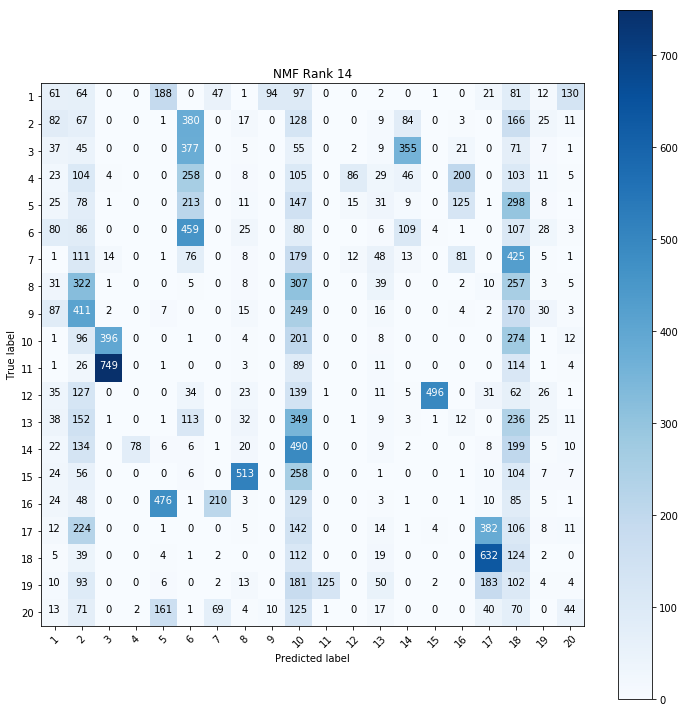

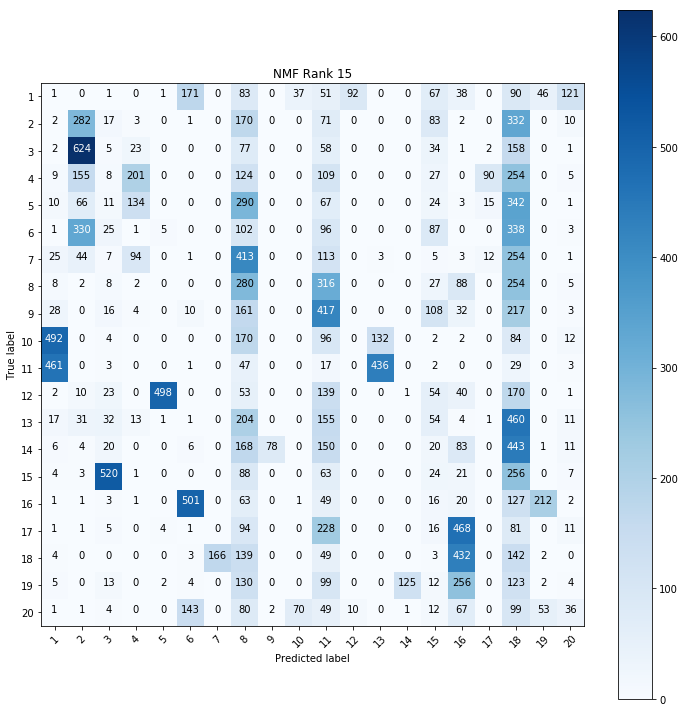

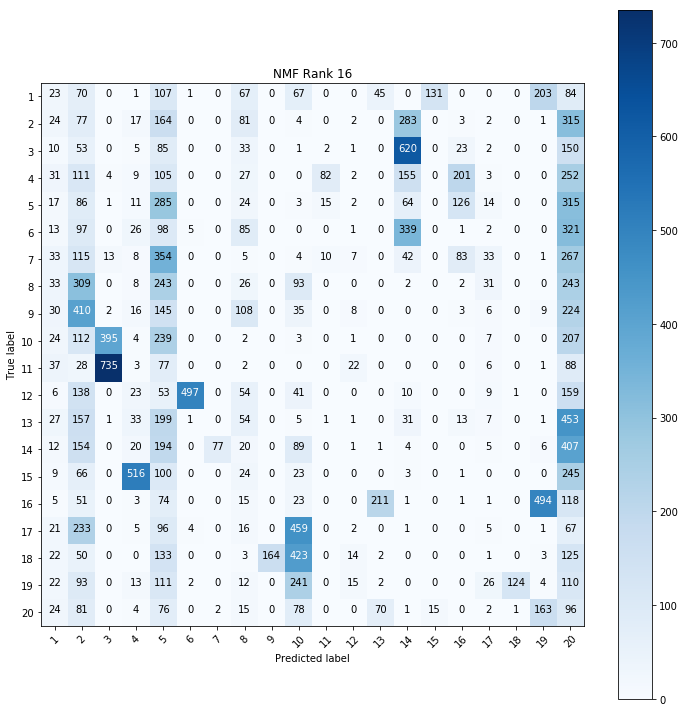

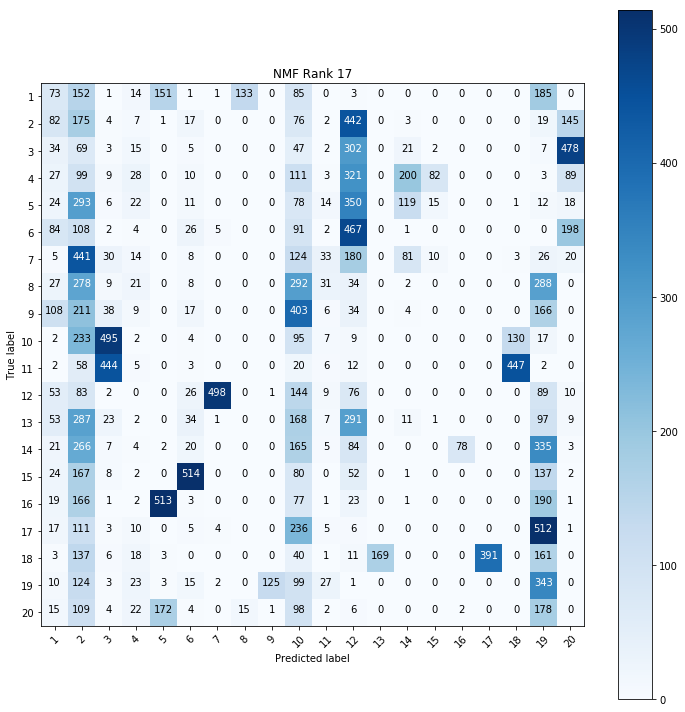

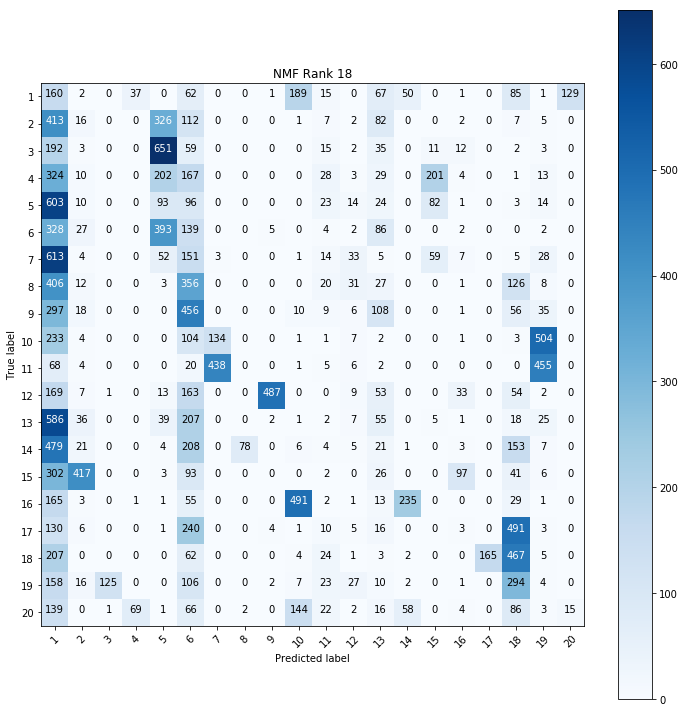

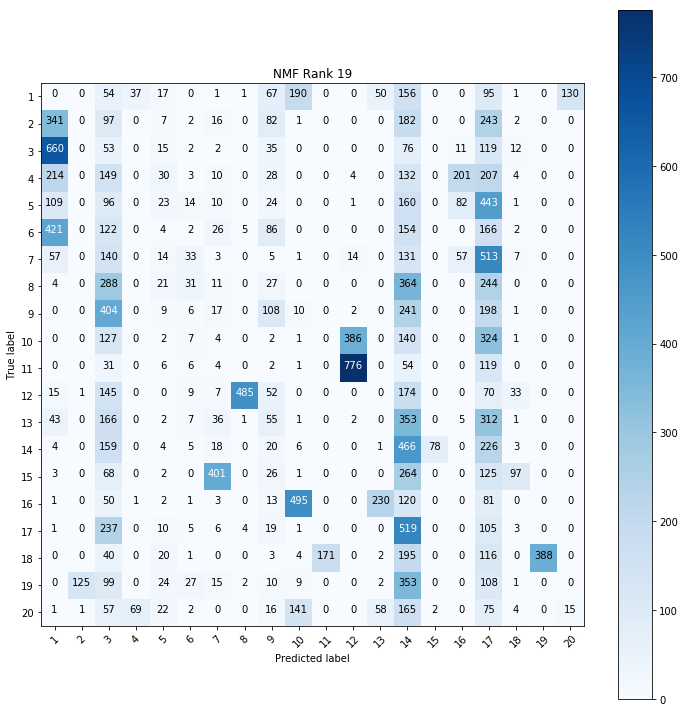

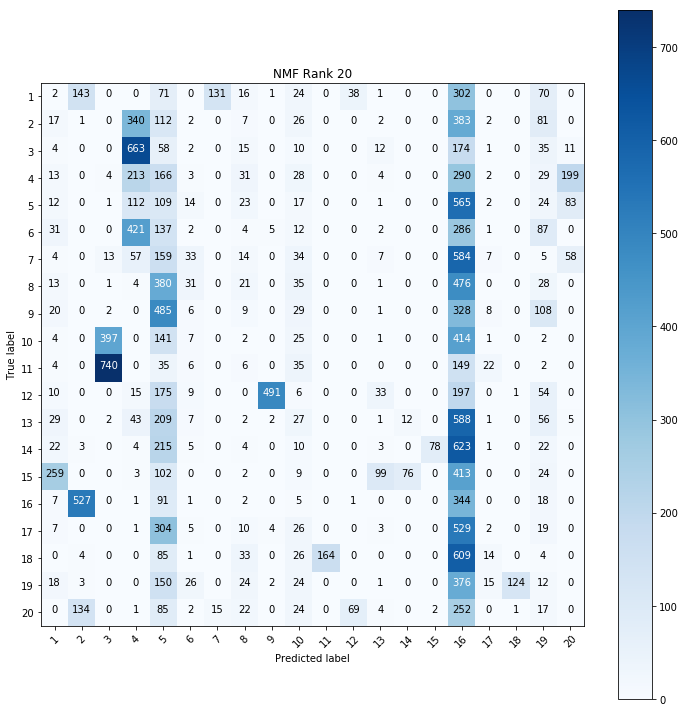

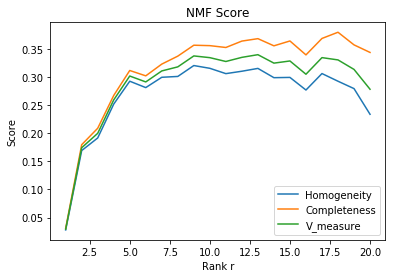

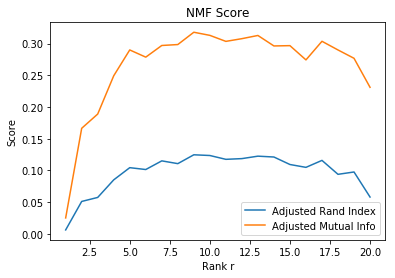

In [217]:
hg, cp, vm, ari, ami = prob5('NMF', tfidf=TFIDF20)

In [223]:
print(np.argmax(ami))
print(ami)
print(ami[8])

8
[ 0.02499419  0.16634976  0.18882729  0.24918082  0.28993243  0.27857259
  0.29695021  0.29842204  0.31783631  0.3129256   0.30343661  0.30770415
  0.31274695  0.29622373  0.29670077  0.27422349  0.30356602  0.28989982
  0.27675071  0.23097824]
0.317836308872


### Visualize Best Clustering Results

In [255]:
from sklearn.decomposition import PCA
best_SVD20 = 10
best_NMF20 = 10

svd_20 = svd_20[:,:best_SVD20]
reduced_SVD = PCA(n_components=2).fit_transform(svd_20)

nmf = NMF(n_components=best_NMF20)
nmf_20 = nmf.fit_transform(TFIDF20)
reduced_NMF = PCA(n_components=2).fit_transform(nmf_20)

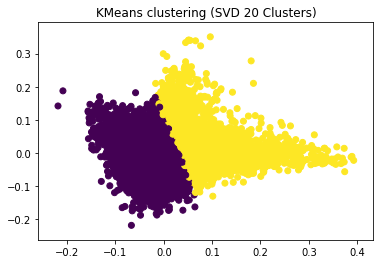

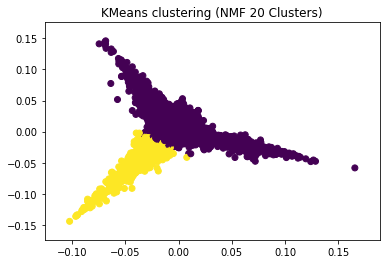

In [257]:
visualize_in_2D('SVD 20 Clusters', reduced_SVD, best_SVD20)
visualize_in_2D('NMF 20 Clusters', reduced_NMF, best_NMF20)

In [263]:
km20 = KMeans(n_clusters=20, max_iter=500, n_init = 100)
km20.fit(svd_20)
print_5measures(twentyLabels, km20.labels_)
km20.fit(nmf_20)
print_5measures(twentyLabels, km20.labels_)

Homogeneity: 0.335
Completeness: 0.374
V-measure: 0.353
Adjusted rand score: 0.135
Adjusted mutual info score: 0.332
Homogeneity: 0.317
Completeness: 0.357
V-measure: 0.336
Adjusted rand score: 0.124
Adjusted mutual info score: 0.315


### Norm Tranformation

Homogeneity: 0.310
Completeness: 0.348
V-measure: 0.328
Adjusted rand score: 0.127
Adjusted mutual info score: 0.307


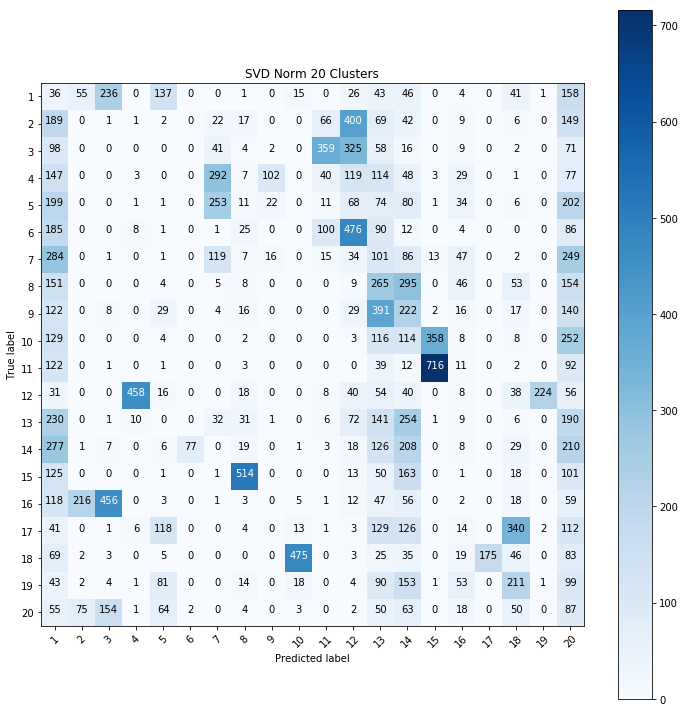

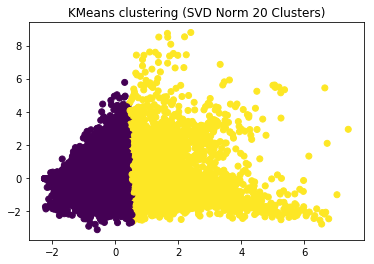

Homogeneity: 0.305
Completeness: 0.341
V-measure: 0.322
Adjusted rand score: 0.117
Adjusted mutual info score: 0.303


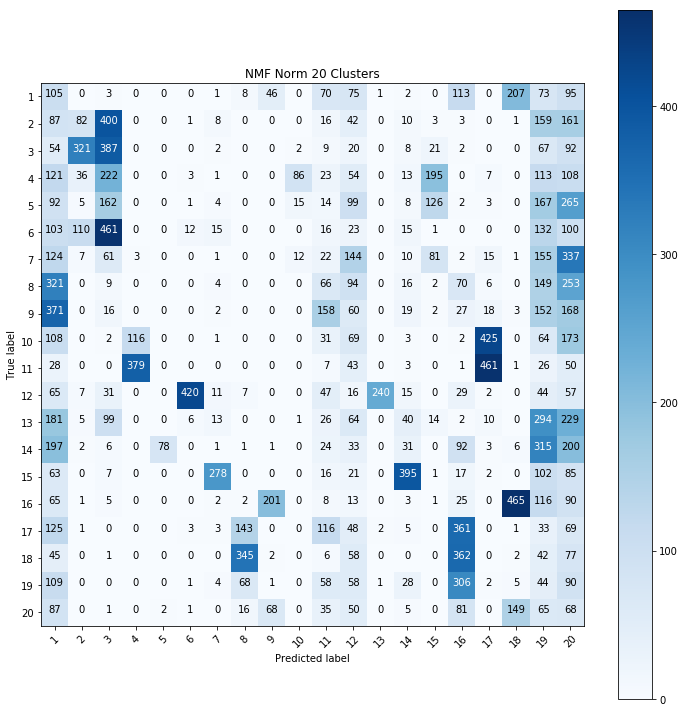

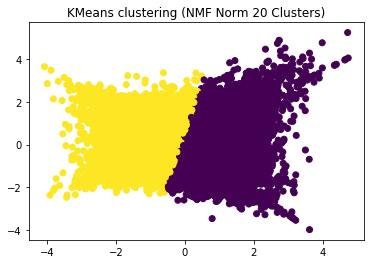

In [259]:
norm_svd20 = scaler.fit_transform(svd_20)
norm_nmf20 = scaler.fit_transform(nmf_20)
km20 = KMeans(n_clusters=20, max_iter=500, n_init = 100)

km20.fit(norm_svd20)
print_5measures(twentyLabels, km20.labels_)
title = 'SVD Norm 20 Clusters'
plot_contingency_matrix(twentyLabels, km20.labels_, classnames, title=title, fs=10)
reduced_Data = PCA(n_components=2).fit_transform(norm_svd20)
visualize_in_2D('SVD Norm 20 Clusters', reduced_Data, best_SVD20)

km20.fit(norm_nmf20)
print_5measures(twentyLabels, km20.labels_)
title = 'NMF Norm 20 Clusters'
plot_contingency_matrix(twentyLabels, km20.labels_, classnames, title=title, fs=10)
reduced_Data = PCA(n_components=2).fit_transform(norm_nmf20)
visualize_in_2D('NMF Norm 20 Clusters', reduced_Data, best_NMF20)


### Log Transformation

Homogeneity: 0.375
Completeness: 0.378
V-measure: 0.376
Adjusted rand score: 0.202
Adjusted mutual info score: 0.373


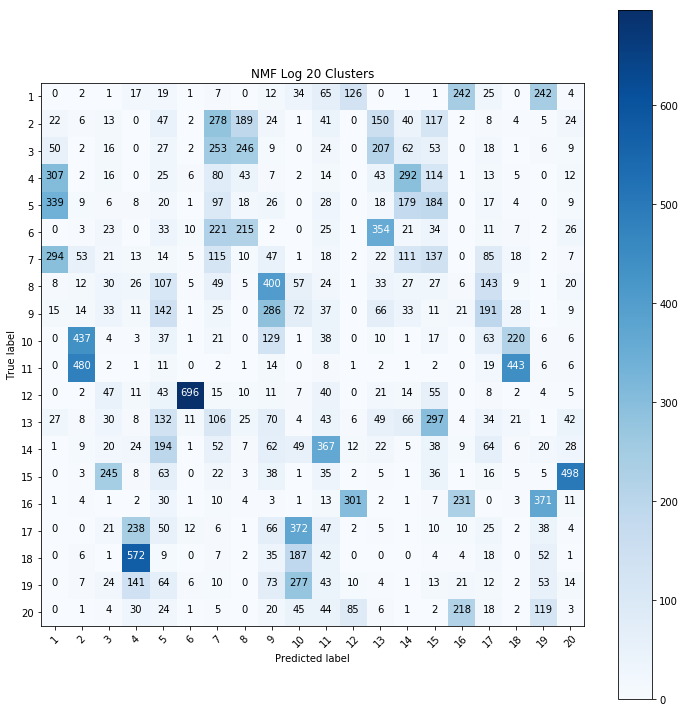

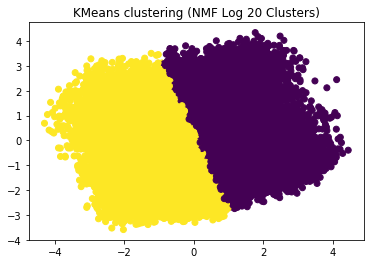

In [260]:
# log
log_nmf20 = np.log(nmf_20+0.001)
km20.fit(log_nmf20)
print_5measures(twentyLabels, km20.labels_)
title = 'NMF Log 20 Clusters'
plot_contingency_matrix(twentyLabels, km20.labels_, classnames, title=title, fs=10)
reduced_Data = PCA(n_components=2).fit_transform(log_nmf20)
visualize_in_2D('NMF Log 20 Clusters', reduced_Data, best_NMF20)

### Norm and then Log

Homogeneity: 0.339
Completeness: 0.355
V-measure: 0.347
Adjusted rand score: 0.150
Adjusted mutual info score: 0.337


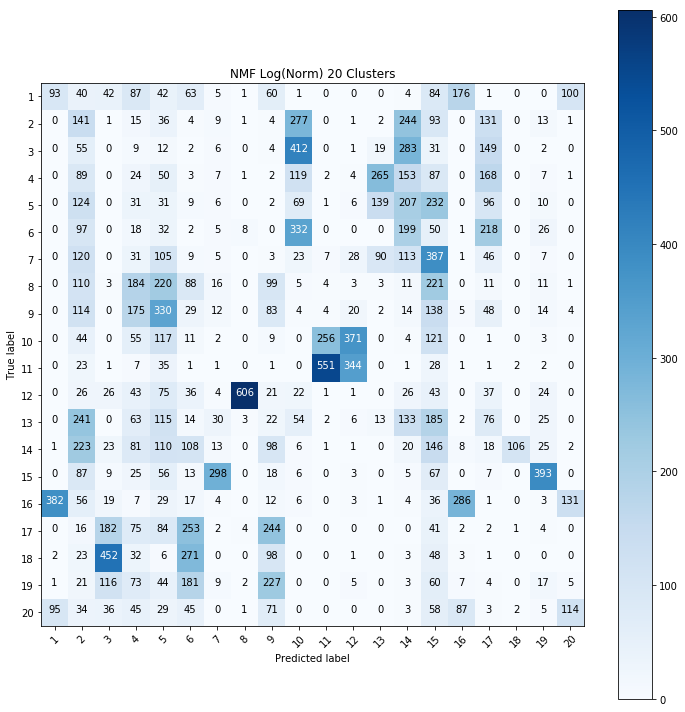

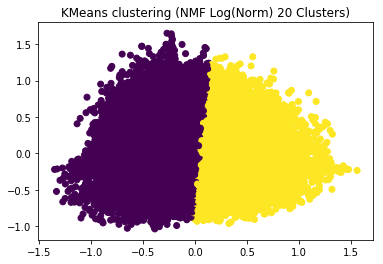

In [261]:
# log_norm
log_norm_nmf20 = np.log(norm_nmf20+2.001)
km20.fit(log_norm_nmf20)
print_5measures(twentyLabels, km20.labels_)
title = 'NMF Log(Norm) 20 Clusters'
plot_contingency_matrix(twentyLabels, km20.labels_, classnames, title=title, fs=10)
reduced_Data = PCA(n_components=2).fit_transform(log_norm_nmf20)
visualize_in_2D('NMF Log(Norm) 20 Clusters', reduced_Data, best_NMF20)


### Log and then Norm

Homogeneity: 0.365
Completeness: 0.367
V-measure: 0.366
Adjusted rand score: 0.199
Adjusted mutual info score: 0.363


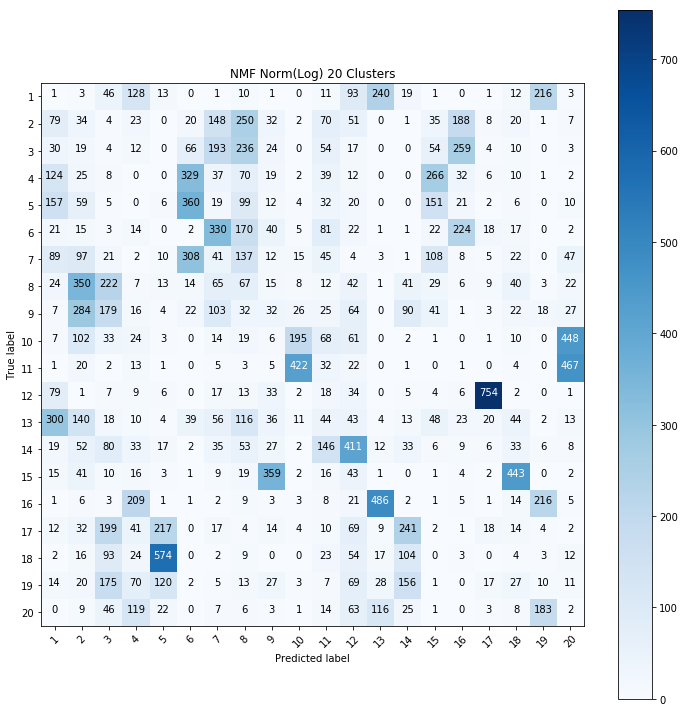

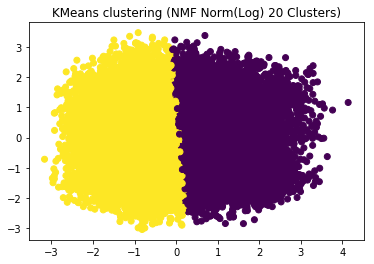

In [262]:
# norm_log
norm_log_nmf20 = scaler.fit_transform(log_nmf20)
km20.fit(norm_log_nmf20)
print_5measures(twentyLabels, km20.labels_)
title = 'NMF Norm(Log) 20 Clusters'
plot_contingency_matrix(twentyLabels, km20.labels_, classnames, title=title, fs=10)
reduced_Data = PCA(n_components=2).fit_transform(norm_log_nmf20)
visualize_in_2D('NMF Norm(Log) 20 Clusters', reduced_Data, best_NMF20)
